(mmm_components)=
# Custom Models with MMM components

The underlying components used in the `MMM` class provide flexibility to build other, custom models. With a little knowledge of `PyMC` and how to customize these `PyMC-Marketing` components, a lot of different use-cases can be covered. 

This notebook is not an introduction but rather an advance example for those trying to understand the `PyMC-Marketing` internals for flexibility for custom use-cases.

## Overview

This notebook will cover the currently exposed model components from the PyMC-Marketing API. At the moment, this includes: 

- media transformations
    - adstock: how today's media has an effect in the future
    - saturation: the diminishing returns for media
- recurring seasonality

For each of these, the flexibility and customization will be showcased and combined together in a toy model with with `PyMC` directly.

## Setup

In [ ]:
from functools import partial

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr
from pymc_extras.prior import Prior

from pymc_marketing import mmm
from pymc_marketing.mmm.events import (
    AsymmetricGaussianBasis,
    EventEffect,
    GaussianBasis,
    HalfGaussianBasis,
)
from pymc_marketing.plot import plot_curve

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%config InlineBackend.figure_format = "retina"

In [2]:
seed = sum(map(ord, "PyMC-Marketing provides flexible model components"))
rng = np.random.default_rng(seed)

draw = partial(pm.draw, random_seed=rng)

## Media Transformations

There are classes for each of the adstock and saturation transformations. They can be imported from the `pymc_marketing.mmm` module.

In [3]:
saturation = mmm.MichaelisMentenSaturation()

Saturation curves can take many different forms. In this example, we will use the Michaelis Menten curve which we provide in the `MichaelisMentenSaturation` class.

This curve has two parameters, `alpha` and `lam`.

A characteristic of these curves are diminishing returns in order to indicate saturation of a media variable. This can be seen in the plateauing as x increases.

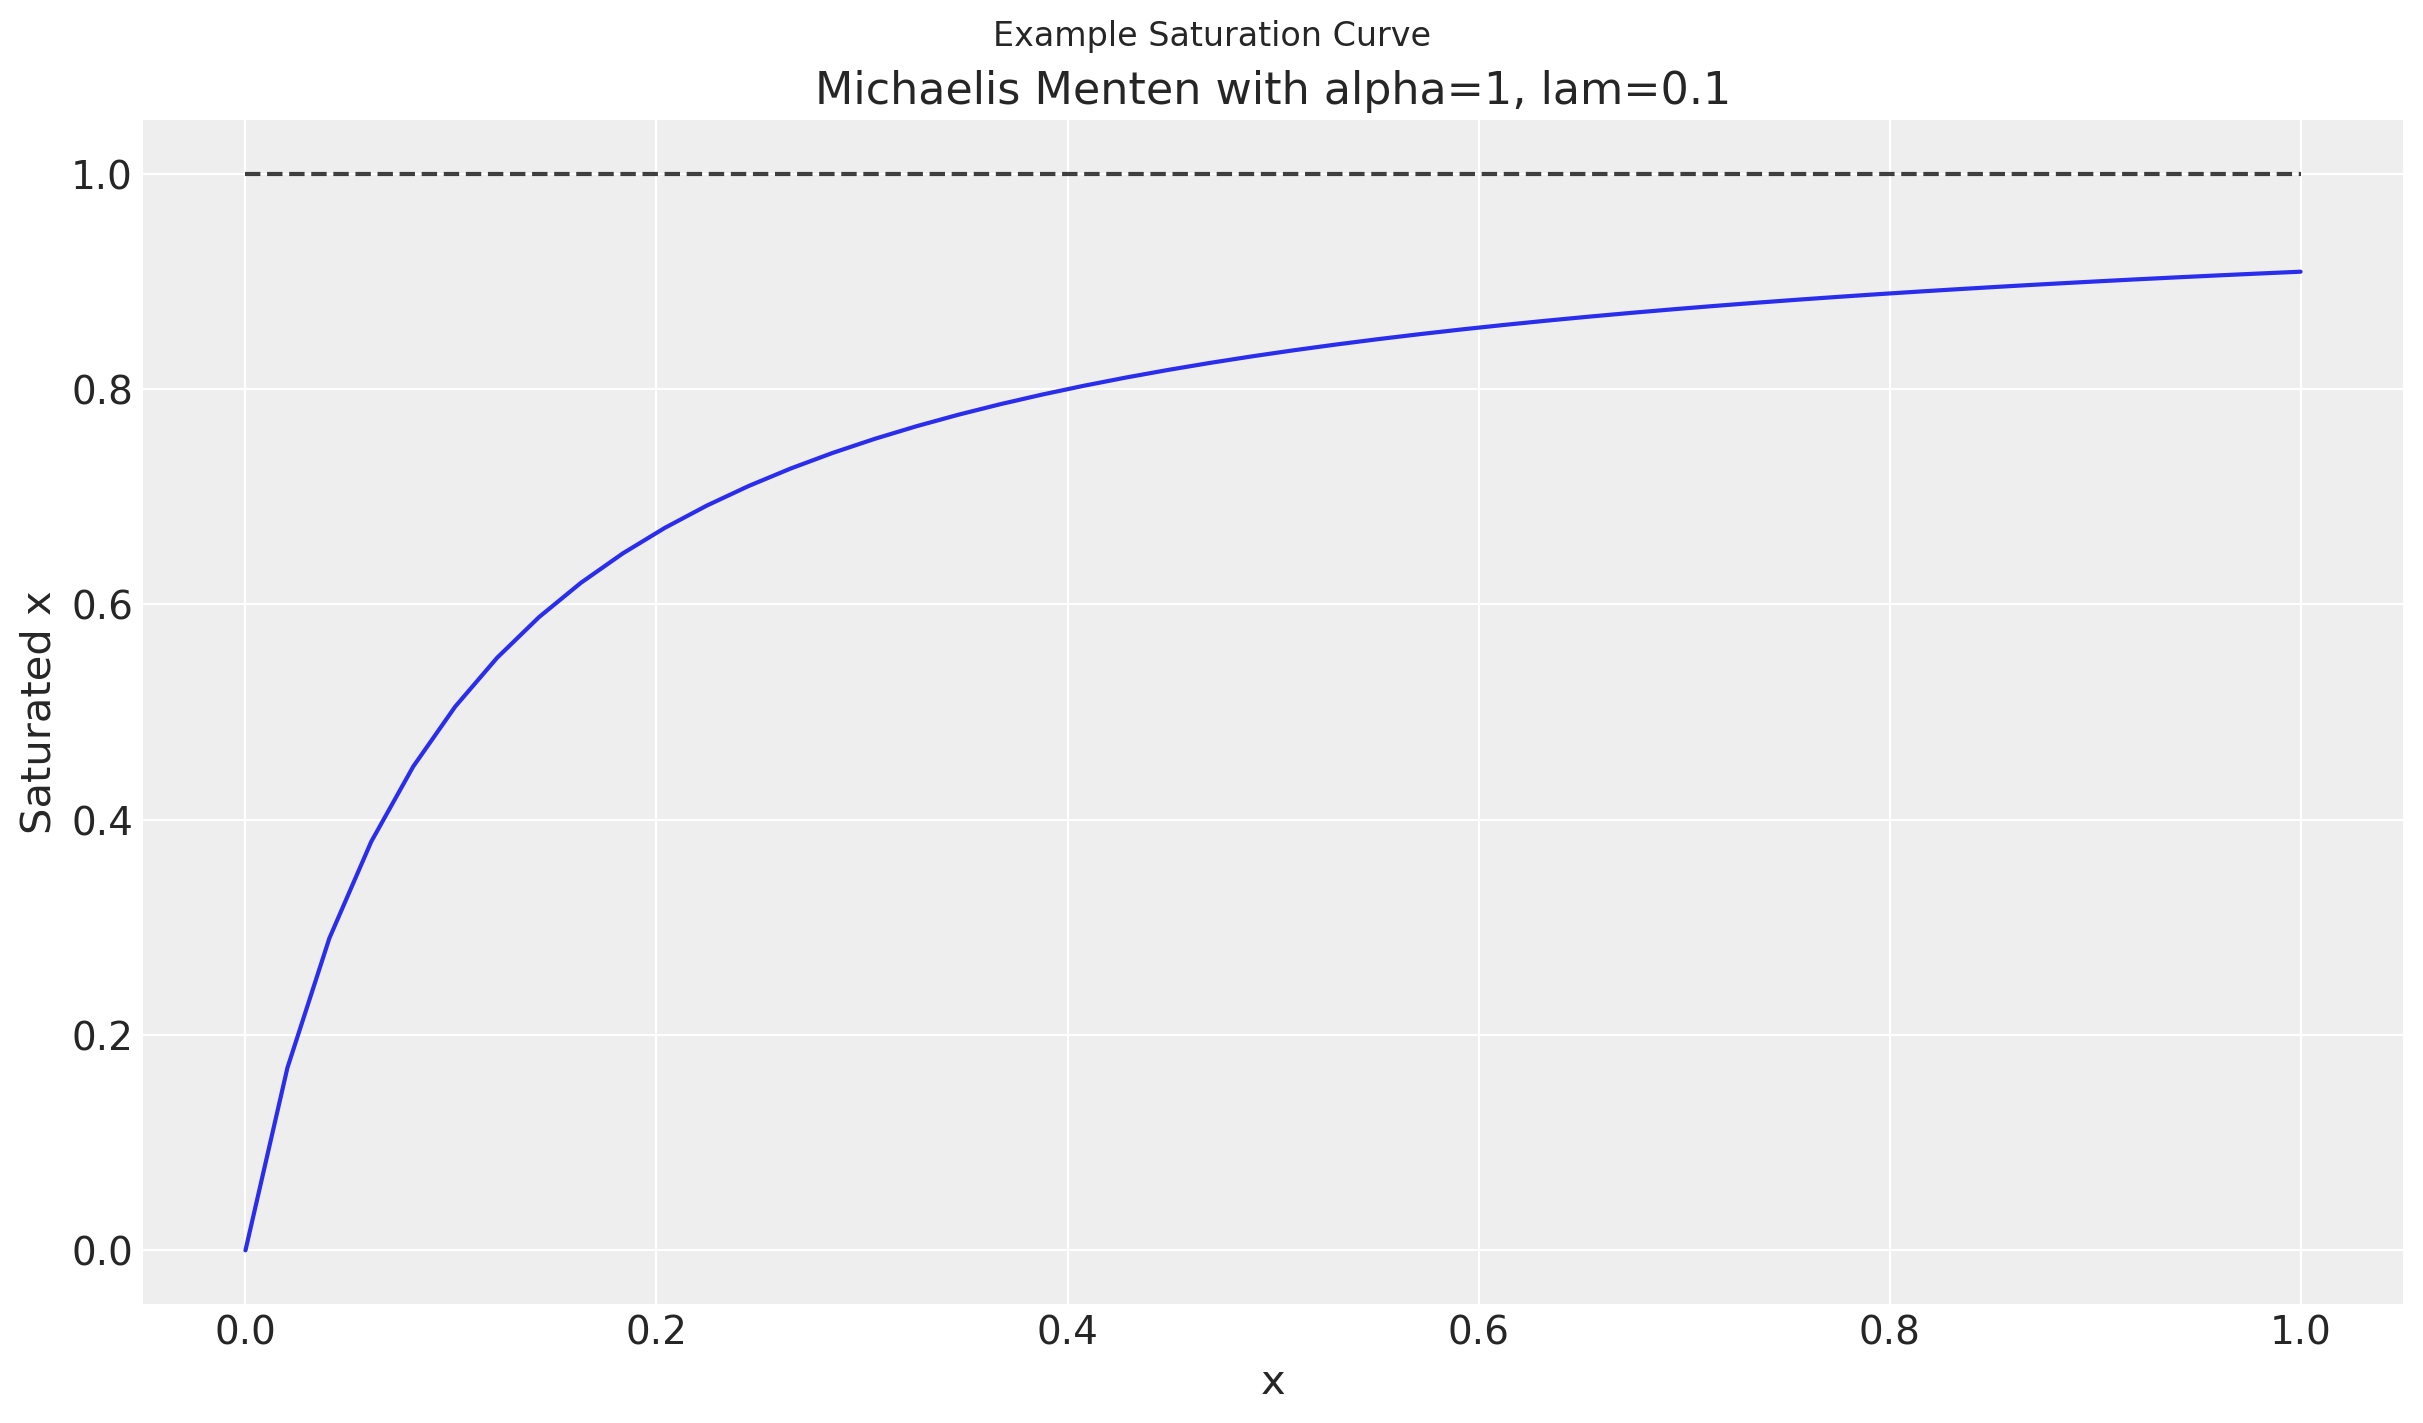

In [4]:
xx = np.linspace(0, 1)

alpha = 1
lam = 1 / 10
yy = saturation.function(xx, alpha=alpha, lam=lam).eval()

fig, ax = plt.subplots()
fig.suptitle("Example Saturation Curve")
ax.plot(xx, yy)
ax.plot(xx, np.ones_like(xx) * alpha, color="black", linestyle="dashed", alpha=0.75)
ax.set(
    xlabel="x",
    ylabel="Saturated x",
    title=f"Michaelis Menten with {alpha=}, {lam=}",
);

### Sampling Transformation Function

Each of the transformation will have a set of default priors. These can be altered at initialization with the `priors` parameter but will ultimately be stored in the `function_priors` attribute of the instance. There will be a prior for each of the estimated parameters used in the function.

In [5]:
saturation.function_priors

{'alpha': Prior("Gamma", mu=2, sigma=1), 'lam': Prior("HalfNormal", sigma=1)}

The `sample_prior` method can be used to sample the parameters of the functions.

```{note}
There is the prefix `saturation_` on each of the parameters in order to not clash with the larger model. This is the default but can be changed as well.
```

In [6]:
parameters = saturation.sample_prior(random_seed=rng)
parameters

Sampling: [saturation_alpha, saturation_lam]


<xarray.Dataset> Size: 12kB
Dimensions:           (chain: 1, draw: 500)
Coordinates:
  * chain             (chain) int64 8B 0
  * draw              (draw) int64 4kB 0 1 2 3 4 5 6 ... 494 495 496 497 498 499
Data variables:
    saturation_alpha  (chain, draw) float64 4kB 2.114 0.8256 ... 2.056 2.347
    saturation_lam    (chain, draw) float64 4kB 0.7597 0.09256 ... 0.8022 0.8724
Attributes:
    created_at:                 2025-08-29T19:16:09.403088+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.25.1

With parameters for the function, the curve can be sampled as well. Combining `sample_curve` and `plot_curve` together can provide good insight into the shape the curve makes!

This shows the most likely curves under the prior distributions.

Sampling: []


Output()

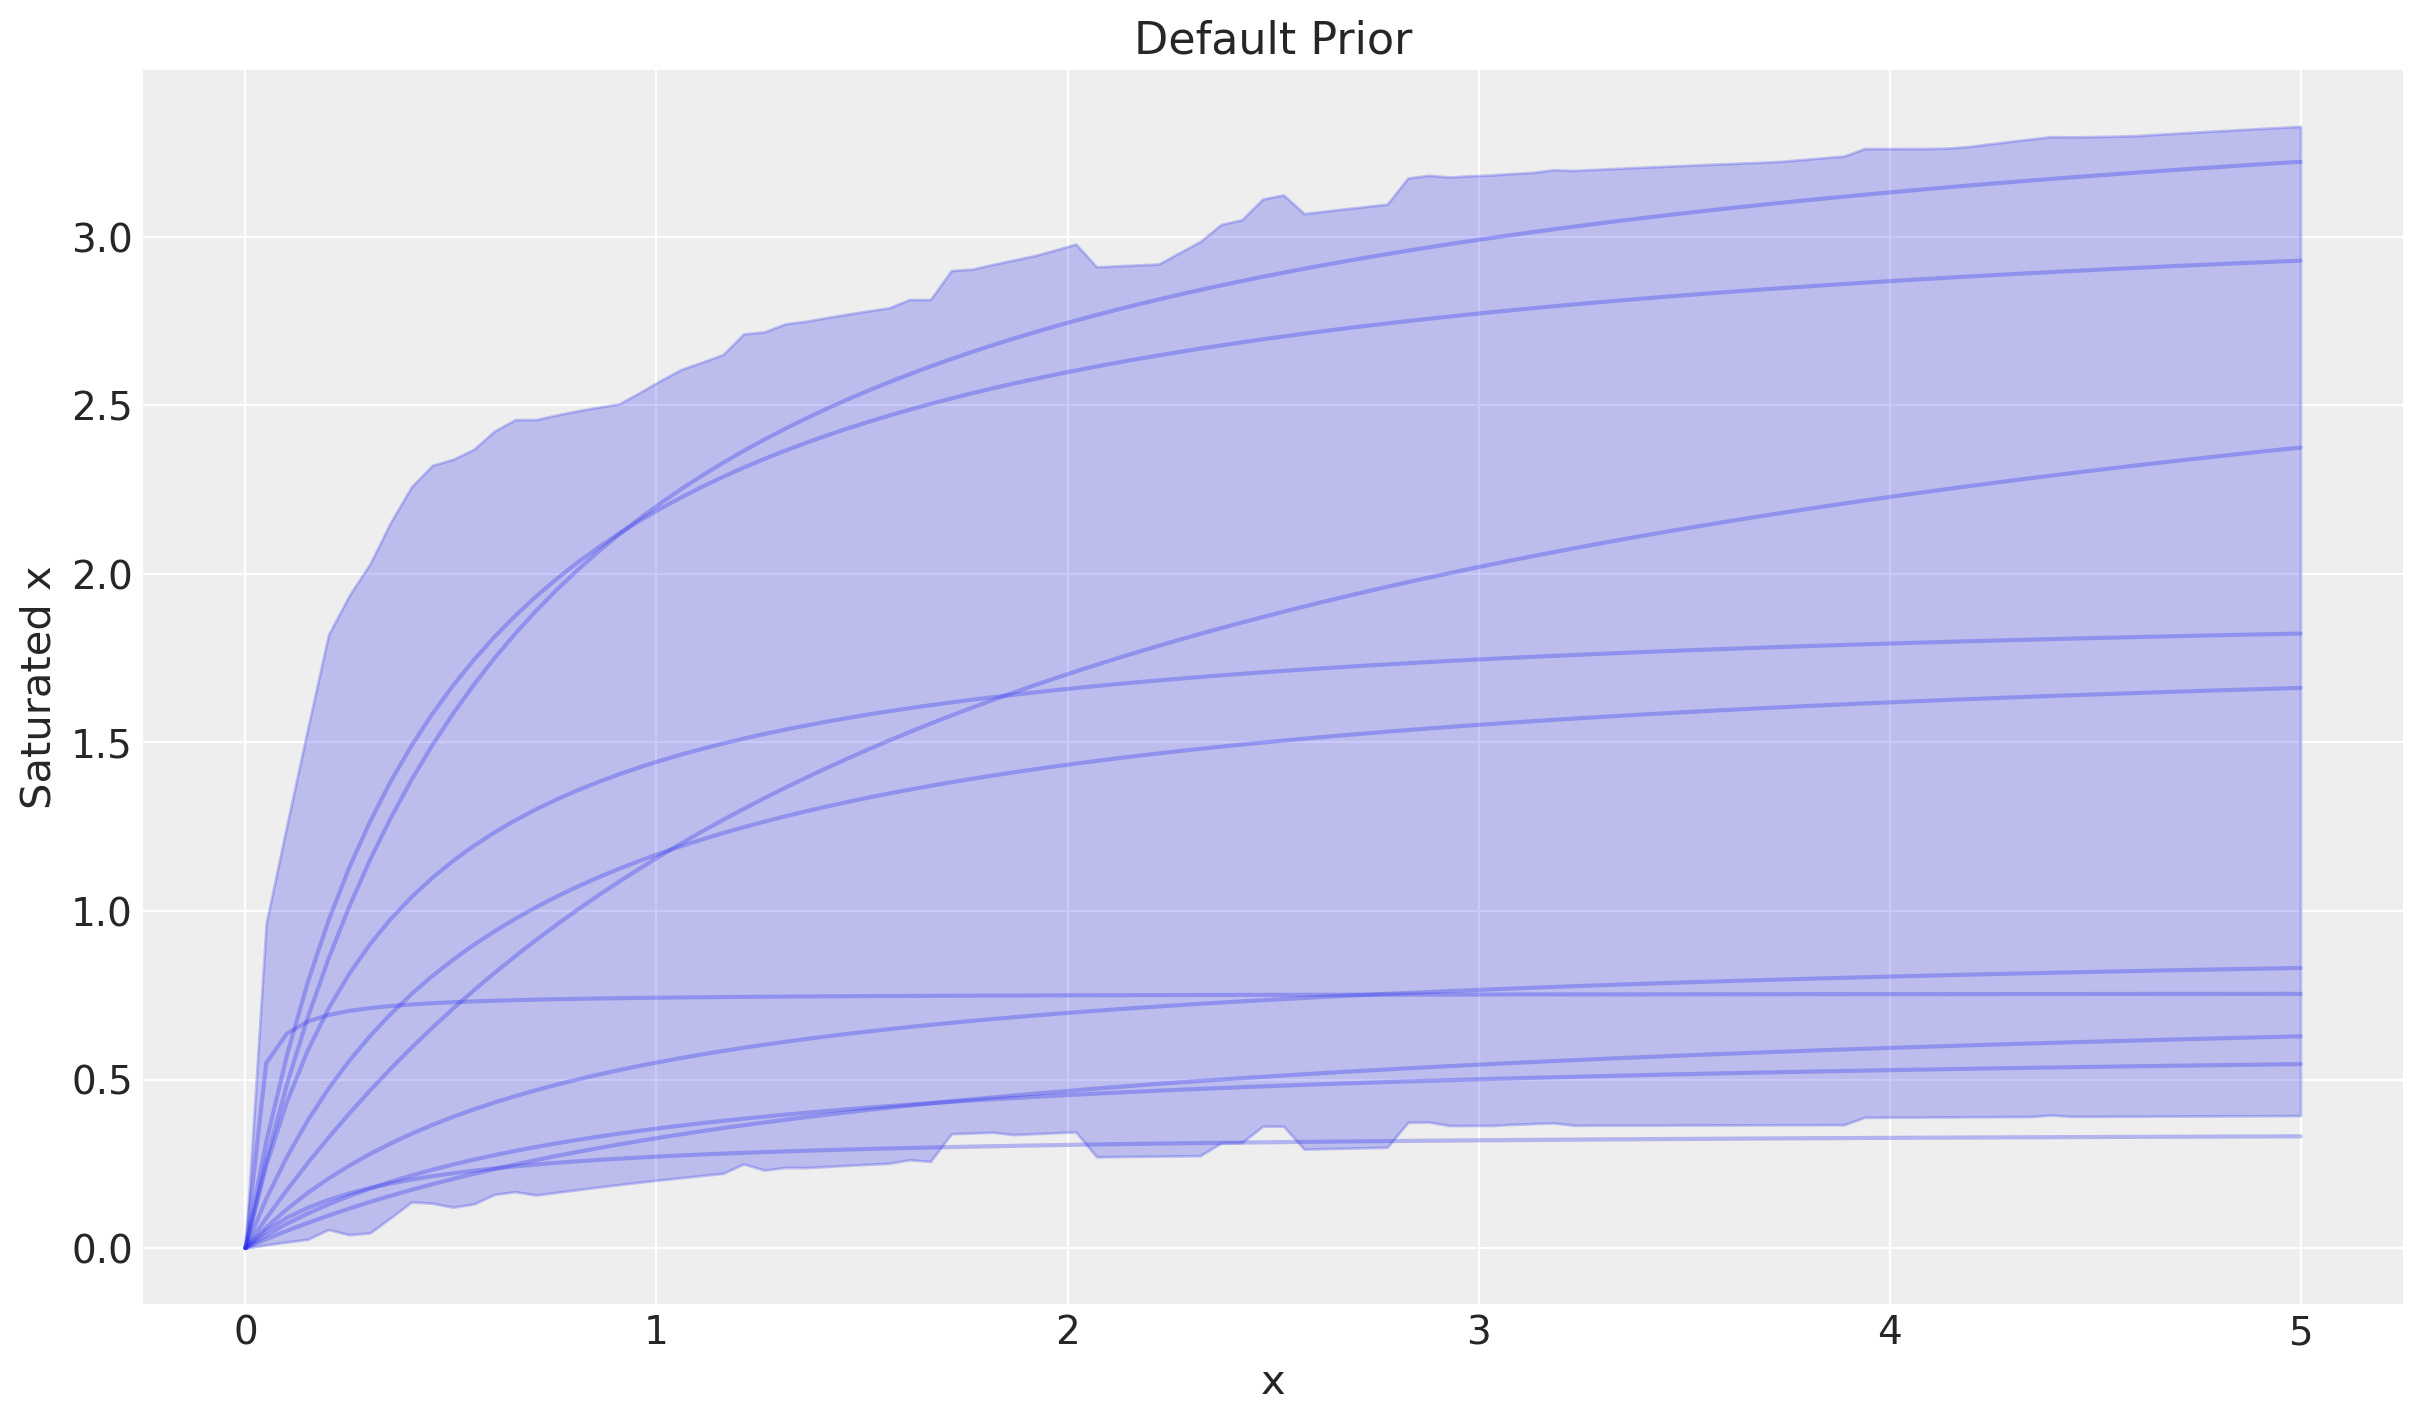

In [7]:
curve = saturation.sample_curve(parameters, max_value=5)
_, axes = saturation.plot_curve(curve)
axes[0].set(
    ylabel="Saturated x",
    title="Default Prior",
);

```{tip}
The posterior can be used instead of the prior in both the `sample_curve` and `plot_curve` methods. Any additional coordinates from the parameters will be handled automatically!
```

### Adding Parameter Dimensions

In most cases, a separate saturation function will be estimated for each media channel. A dimension needs to be added to the prior of the function parameters to account for this.

Let's create some example data to work toward this transformation.

In [8]:
def random_spends(coords) -> xr.DataArray:
    """Create random spends that turn off and on."""
    size = tuple([len(values) for values in coords.values()])
    dims = list(coords.keys())

    amount_rv = pm.HalfNormal.dist(size=size)
    stopped_rv = pm.Normal.dist(size=size).cumsum(axis=0) <= 0
    spends_rv = amount_rv * stopped_rv

    return xr.DataArray(
        draw(spends_rv),
        coords=coords,
        dims=dims,
        name="spends",
    )

For this example, we will have 2 years of media spend for 4 channels

In [9]:
n_dates = 52 * 2
dates = pd.date_range("2023-01-01", periods=n_dates, freq="W-MON")

channels = ["C1", "C2", "C3", "C4"]

coords = {
    "date": dates,
    "channel": channels,
}

In [10]:
df_spends = random_spends(coords=coords).to_pandas()
df_spends.head()

channel,C1,C2,C3,C4
date,,,,
2023-01-02,0.0,0.992756,0.000000,0.000000
2023-01-09,0.0,0.902103,0.203395,0.000000
2023-01-16,0.0,0.559487,0.000000,0.000000
2023-01-23,0.0,0.990124,0.000000,2.013755
2023-01-30,0.0,0.753384,0.000000,0.377570


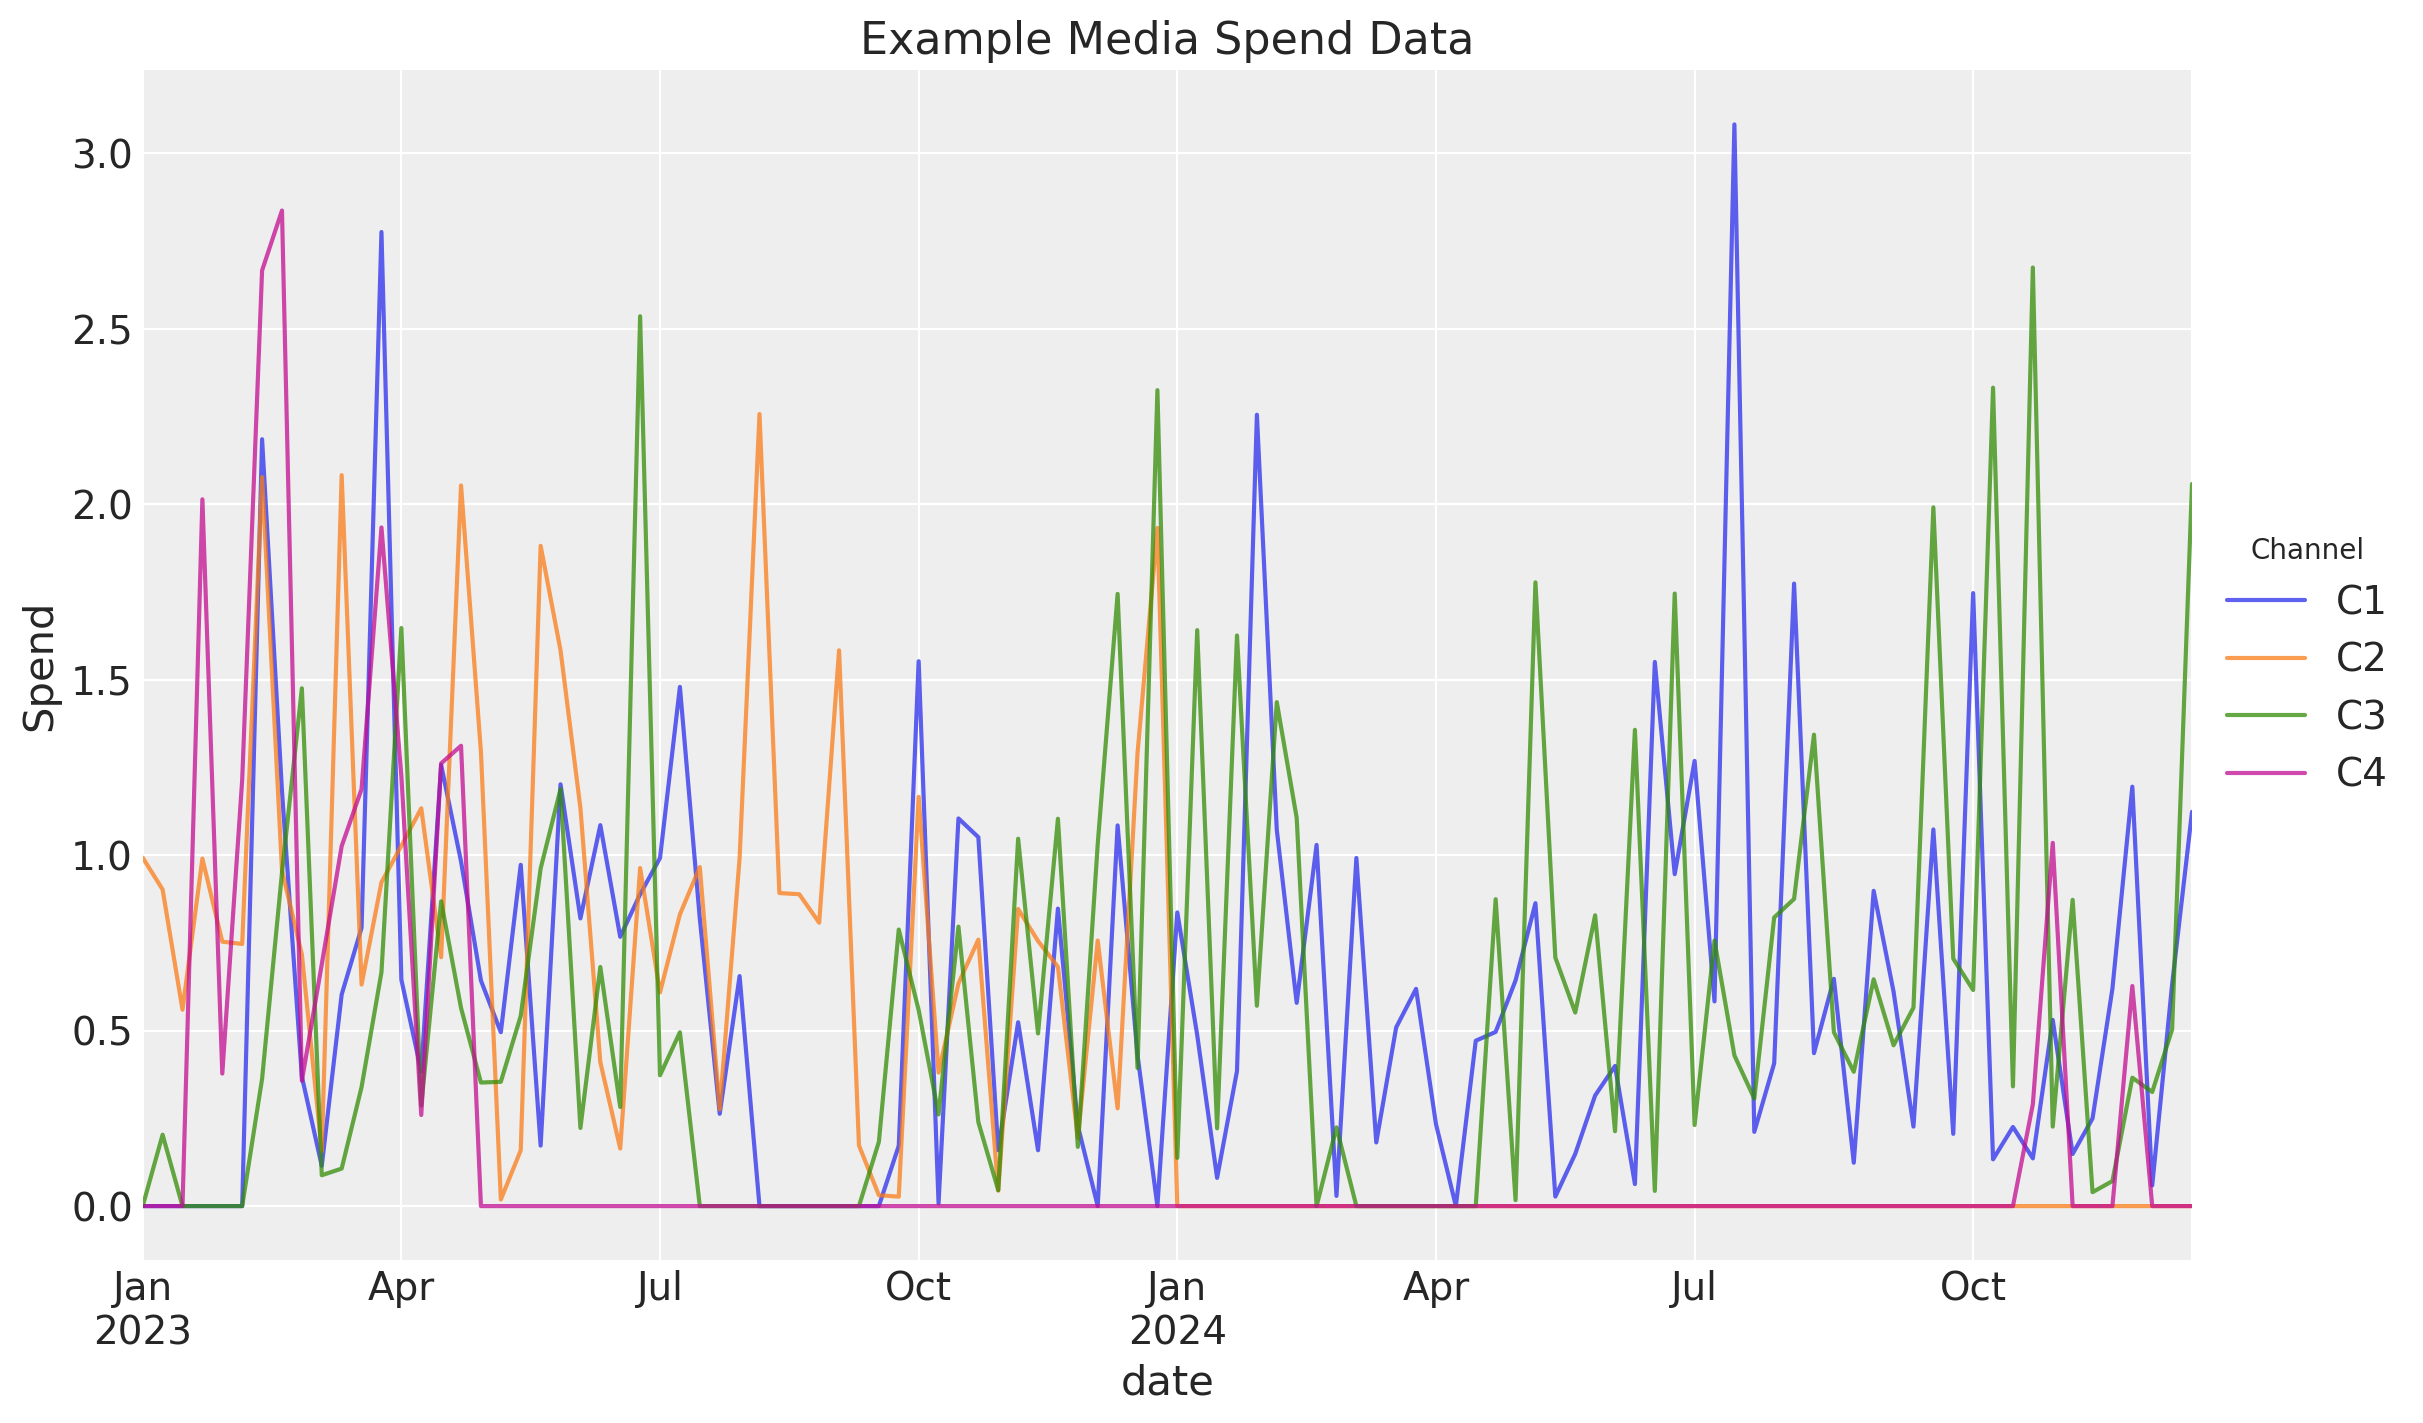

In [11]:
ax = df_spends.plot(title="Example Media Spend Data", ylabel="Spend", alpha=0.75)
ax.legend(title="Channel", loc="center left", bbox_to_anchor=(1, 0.5));

As mentioned, the default priors **do not** have a channel dimension. In order to use with the in our model with "channel" dim, we have to add the dims to each of the function priors.

In [13]:
for dist in saturation.function_priors.values():
    dist.dims = "channel"

saturation.function_priors

{'alpha': Prior("Gamma", mu=2, sigma=1, dims="channel"),
 'lam': Prior("HalfNormal", sigma=1, dims="channel")}

The previous workflow can be used to understand our priors still. Just pass the `coords` to the `sample_prior` method in order to add dims to the appropriate variables.

In [14]:
prior = saturation.sample_prior(coords=coords, random_seed=rng)
prior

Sampling: [saturation_alpha, saturation_lam]


<xarray.Dataset> Size: 36kB
Dimensions:           (chain: 1, draw: 500, channel: 4)
Coordinates:
  * chain             (chain) int64 8B 0
  * draw              (draw) int64 4kB 0 1 2 3 4 5 6 ... 494 495 496 497 498 499
  * channel           (channel) <U2 32B 'C1' 'C2' 'C3' 'C4'
Data variables:
    saturation_alpha  (chain, draw, channel) float64 16kB 1.348 2.211 ... 2.639
    saturation_lam    (chain, draw, channel) float64 16kB 0.6277 ... 1.778
Attributes:
    created_at:                 2025-08-29T19:17:06.918374+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.25.1

Since each channel prior is the same, there will just be some noise between the HDI and curve samples.

Sampling: []


Output()

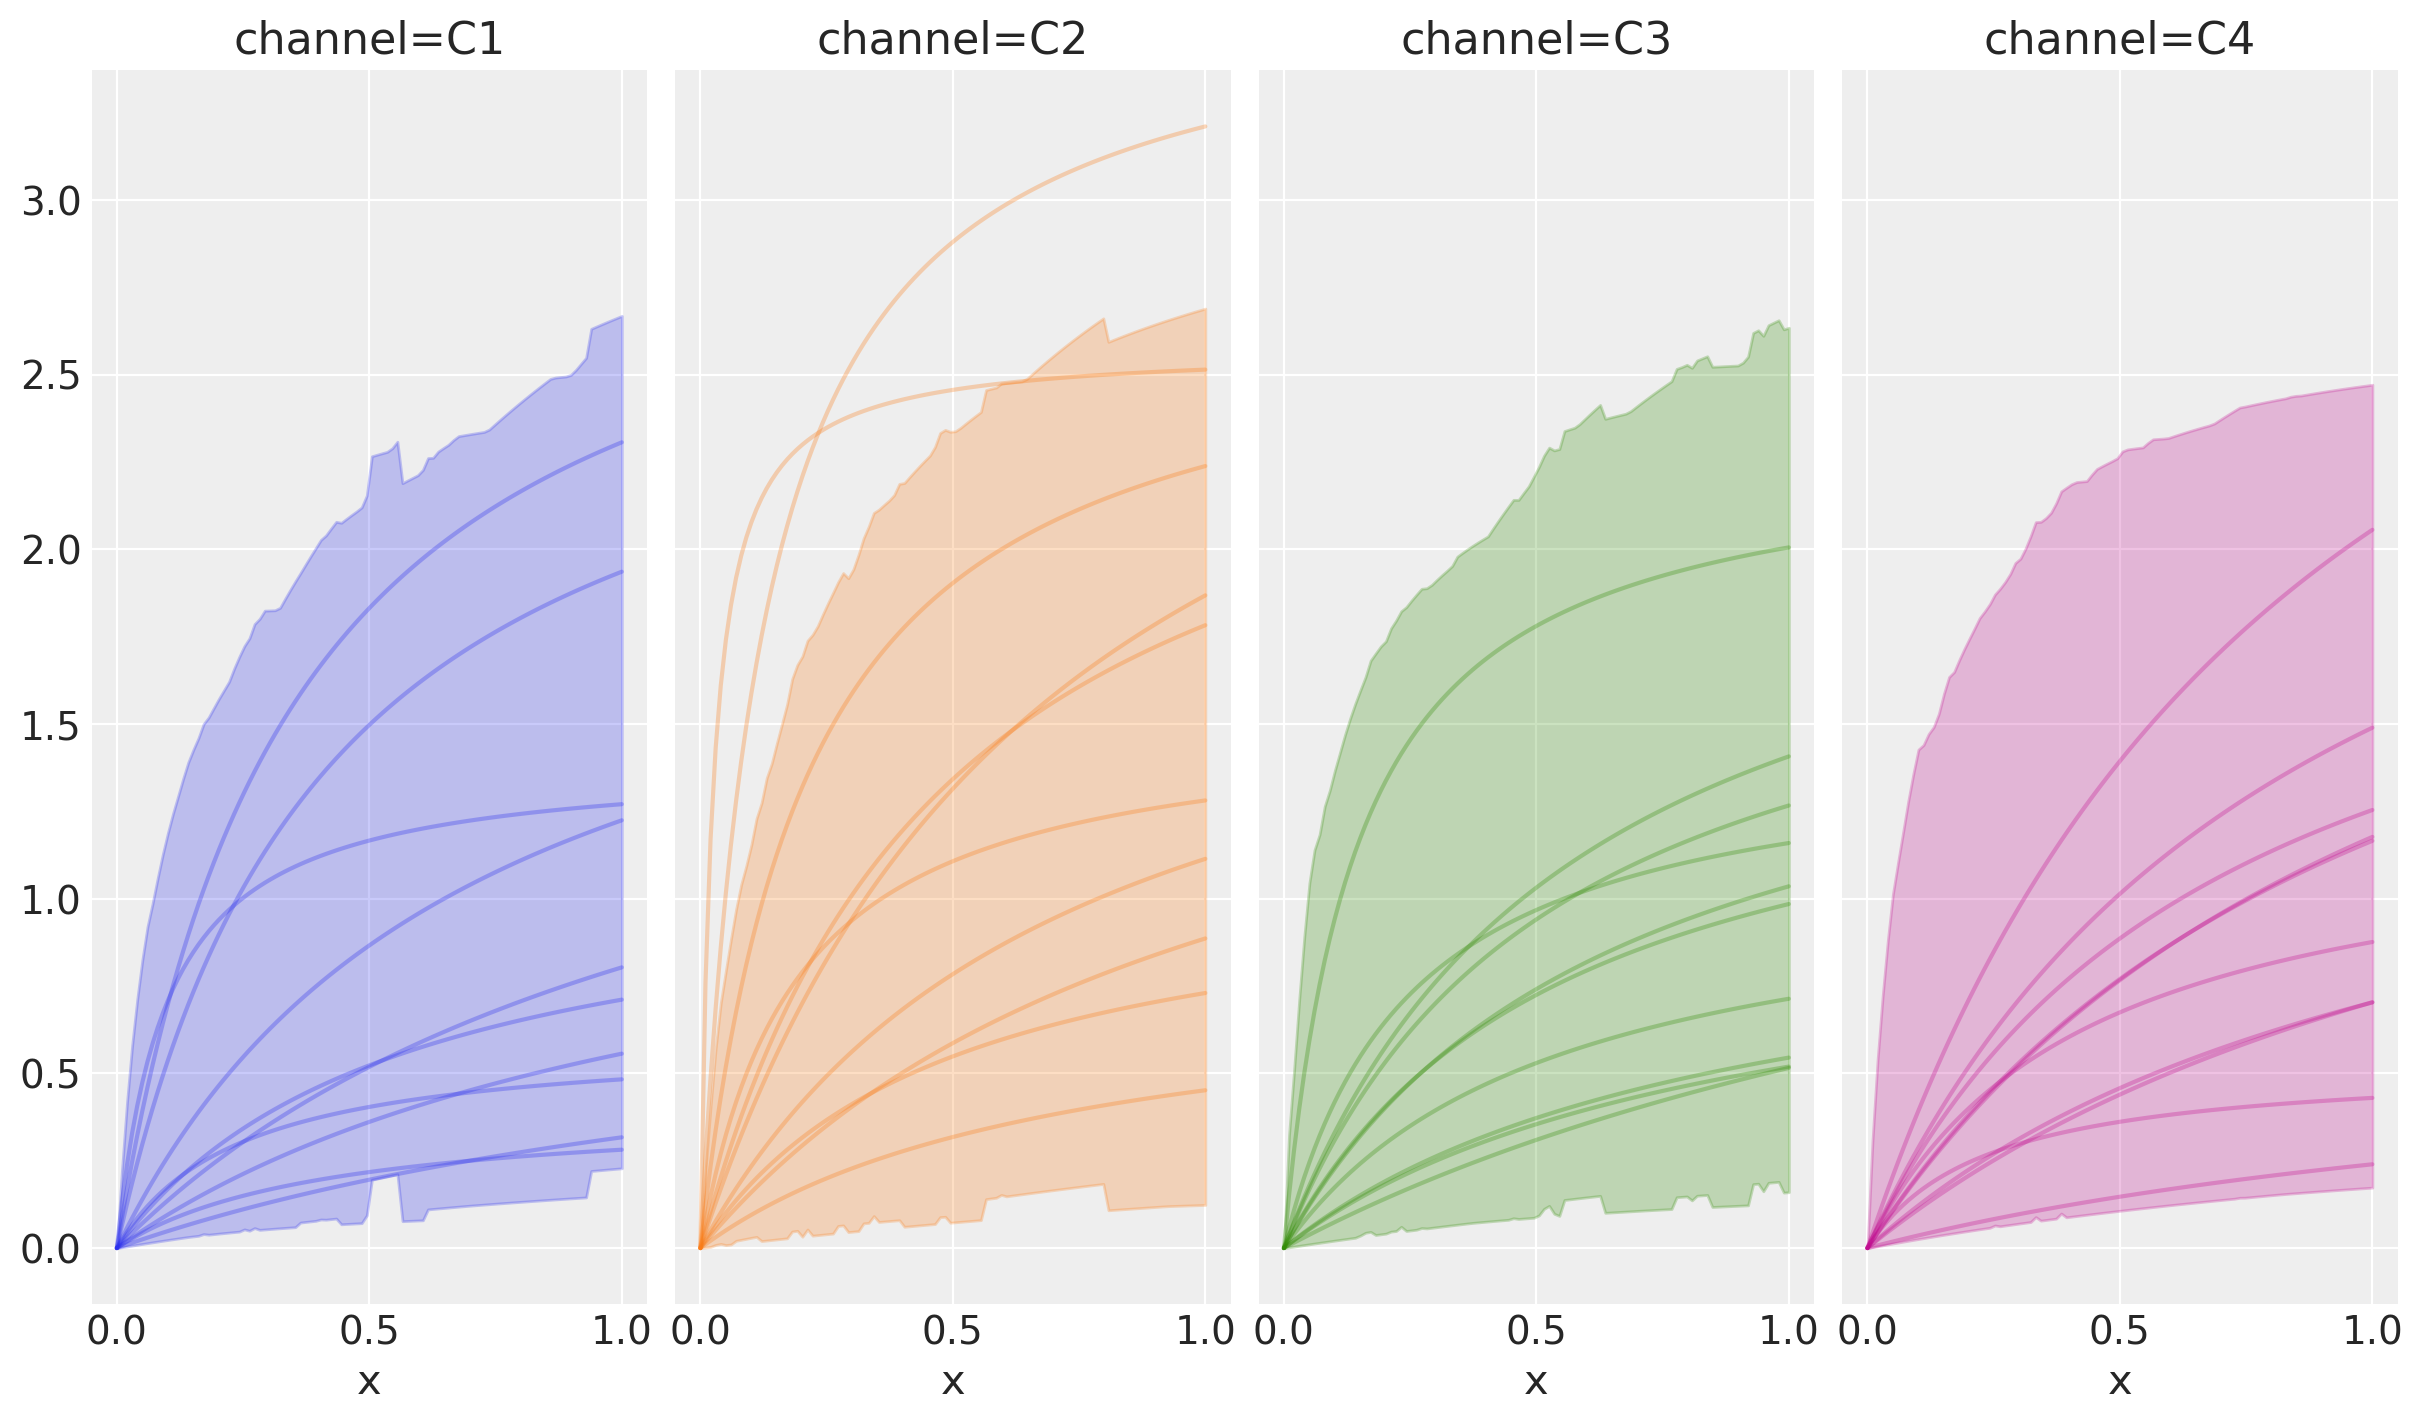

In [15]:
curve = saturation.sample_curve(prior)
saturation.plot_curve(curve);

### Using in PyMC Model

When using the transformation in a larger `PyMC` model, the `apply` method will be used.

This method will: 

- create distributions based on prior specification of the instance
- apply the transformation to the data

The `dims` parameter is the shape of parameters and not the data. The data has a different shape but will need to be broadcastable with the parameters!

In [16]:
with pm.Model(coords=coords) as model:
    saturated_spends = saturation.apply(df_spends, dims="channel")

Since independent alpha and lam were specified, we see that in the model graph below:

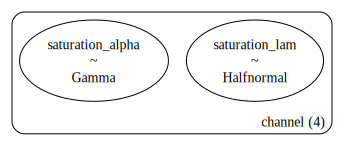

In [17]:
pm.model_to_graphviz(model)

```{note}
Neither the `df_spends` nor `saturated_spends` show in the model. If needed, use `pm.Data` and `pm.Deterministic` to save off.
```

Our variable will be (date, channel) dims.

In [18]:
saturated_spends.type.shape

We can manipulate this in anyway we'd like to connect it in with the larger model.

### Changing Assumptions

As hinted above, the priors for the function parameters are customizable which can lead to many different models. Change the priors, change the model.

The prior distributions just need to follow the distribution API [here](https://www.pymc-marketing.io/en/stable/api/generated/pymc_marketing.model_config.html).

Instead of the defaults, we can use:
- hierarchical parameter for `lam` parameter
- common `alpha` parameter
  

In [19]:
hierarchical_lam = Prior(
    "HalfNormal",
    sigma=Prior("HalfNormal", sigma=1),
    dims="channel",
)
common_alpha = Prior("Gamma", mu=2, sigma=1)
priors = {
    "lam": hierarchical_lam,
    "alpha": common_alpha,
}

saturation = mmm.MichaelisMentenSaturation(priors=priors)

saturation.function_priors

{'alpha': Prior("Gamma", mu=2, sigma=1),
 'lam': Prior("HalfNormal", sigma=Prior("HalfNormal", sigma=1), dims="channel")}

Then this can be used in a new `PyMC` model which leads to a much different model graph than before!

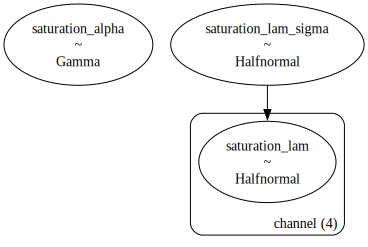

In [20]:
with pm.Model(coords=coords) as model:
    saturated_spends = saturation.apply(df_spends, dims="channel")

pm.model_to_graphviz(model)

The shape of the output will still be (date, channel) even though some of the parameter's dims has changed.

In [21]:
saturated_spends.type.shape

The previous workflow still helps us understand the produced curves: 

- `sample_prior`
- `sample_curve`
- `plot_curve`

In [22]:
prior = saturation.sample_prior(coords=coords, random_seed=rng)

Sampling: [saturation_alpha, saturation_lam, saturation_lam_sigma]


Though they all look the same in the prior, the data generation process is indeed different as seen in the model graph.

Sampling: []


Output()

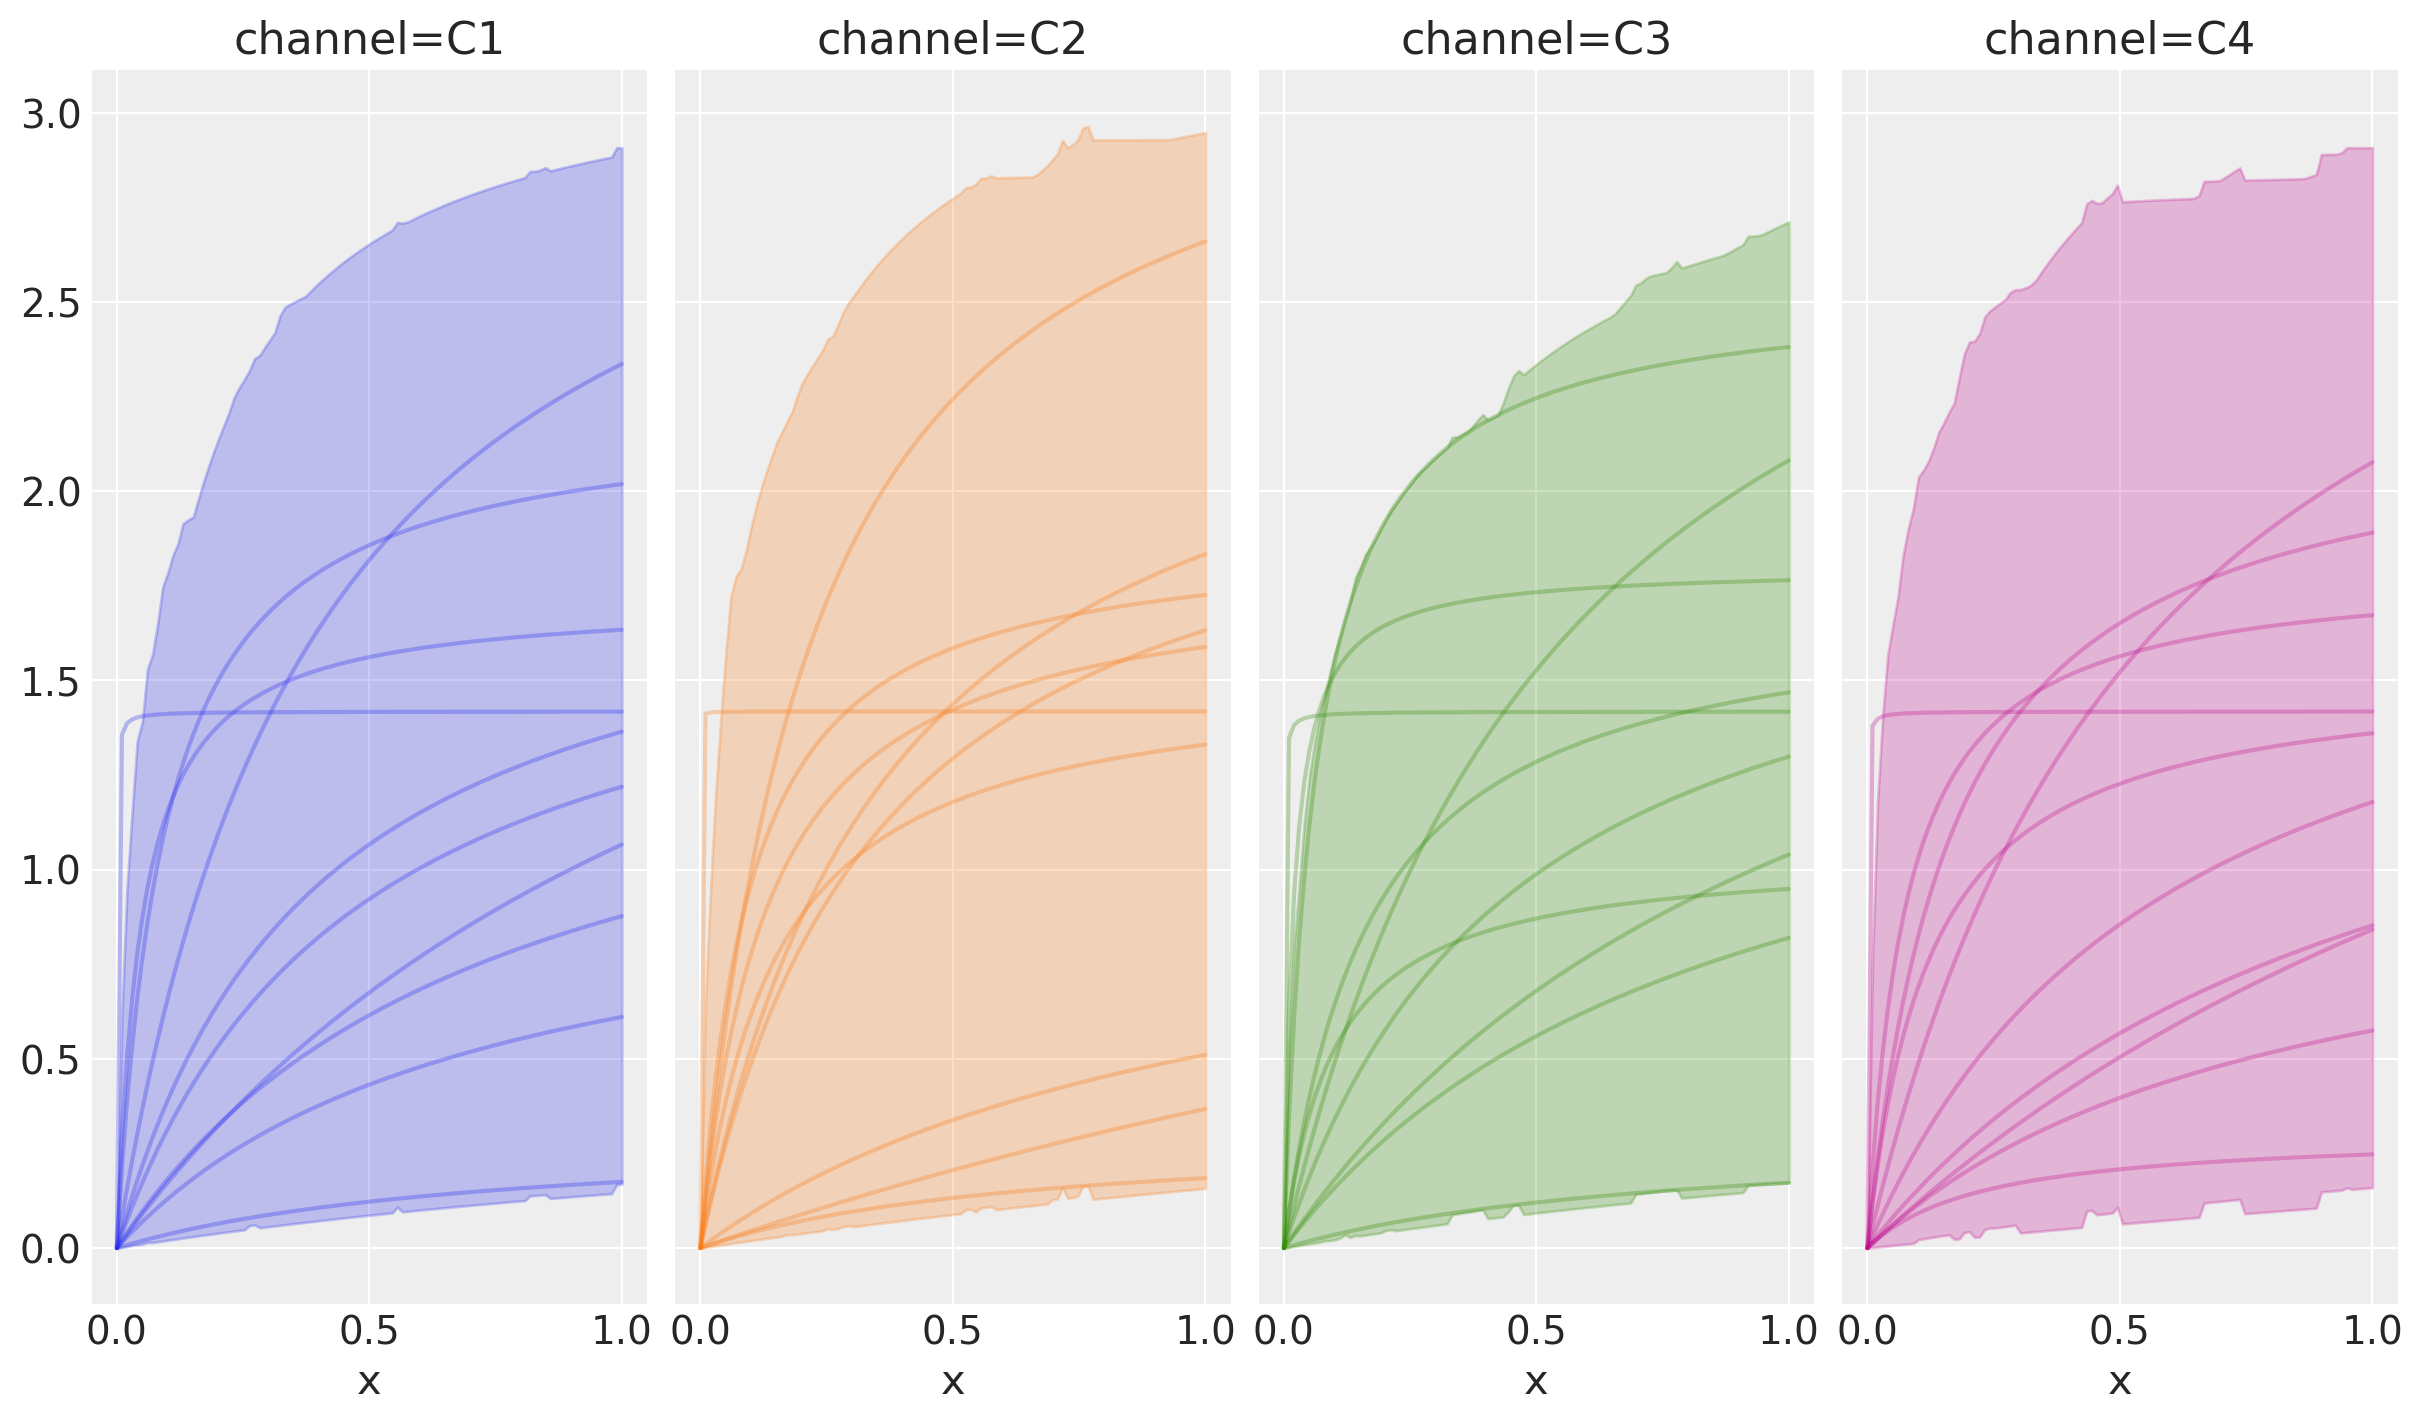

In [23]:
curve = saturation.sample_curve(prior)
saturation.plot_curve(curve);

#### Geo Hierarchical Model

The dimensions of the parameters are not limited to 1D so additional hierarchies can be defined. 

Below defines: 

- alpha which is hierarchical across channels
- lam which is common across all geos but different channels

In [24]:
# For reference
mmm.MichaelisMentenSaturation.default_priors

{'alpha': Prior("Gamma", mu=2, sigma=1), 'lam': Prior("HalfNormal", sigma=1)}

In [25]:
hierarchical_alpha = Prior(
    "Gamma",
    mu=Prior("HalfNormal", sigma=1, dims="geo"),
    sigma=Prior("HalfNormal", sigma=1, dims="geo"),
    dims=("channel", "geo"),
)
common_lam = Prior("HalfNormal", sigma=1, dims="channel")
priors = {
    "alpha": hierarchical_alpha,
    "lam": common_lam,
}
saturation = mmm.MichaelisMentenSaturation(priors=priors)

Our new data set needs to have information for geo now. This is channel spends by date **and geo**. This is stored in an `xarray.DataArray` which can be converted to a 3D `numpy.ndarray`.

Displaying the data is easy with pandas.

In [26]:
geo_coords = {
    **coords,
    "geo": ["Region1", "Region2", "Region3"],
}

geo_spends = random_spends(coords=geo_coords)

In [27]:
geo_spends.to_series().unstack("channel").head(6)

channel                   C1        C2        C3   C4
date       geo                                       
2023-01-02 Region1  0.000000  0.000000  0.541483  0.0
           Region2  0.213863  0.000000  0.000000  0.0
           Region3  1.100906  0.692670  1.493263  0.0
2023-01-09 Region1  0.309415  0.614882  0.818824  0.0
           Region2  2.264686  0.930828  0.028902  0.0
           Region3  0.433401  0.660699  1.318996  0.0

As long as the `dims` argument of `apply` can broadcast with the data going in, then the media transformations can be used!

Here, the data is in the shape (date, channel, geo) so it can broadcast with the parameters in shape (channel, geo) to create the saturated spends.

In [28]:
with pm.Model(coords=geo_coords) as geo_model:
    geo_data = pm.Data(
        "geo_data",
        geo_spends.to_numpy(),
        dims=("date", "channel", "geo"),
    )
    saturated_geo_spends = pm.Deterministic(
        "saturated_geo_spends",
        saturation.apply(geo_data, dims=("channel", "geo")),
        dims=("date", "channel", "geo"),
    )

The saturation assumptions can be seen in the model graph:

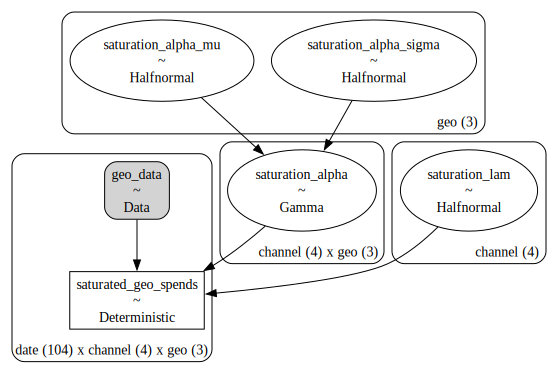

In [29]:
pm.model_to_graphviz(geo_model)

```{tip}
The `PyMC` model context will stay the same but changing model assumptions will happen with input data and prior configuration!
```


## Seasonality

Recurring seasonality can be modeled with either a `MonthlyFourier` or `YearlyFourier` instance.

In [30]:
yearly = mmm.YearlyFourier(n_order=2)

There is a similar workflow to understand these priors as before:

- `sample_prior`: Sample all the priors
- `sample_curve`: Sample the curve across the whole period
- `plot_curve`: Plot the HDI and few samples

Sampling: [fourier_beta]
Sampling: []


Output()

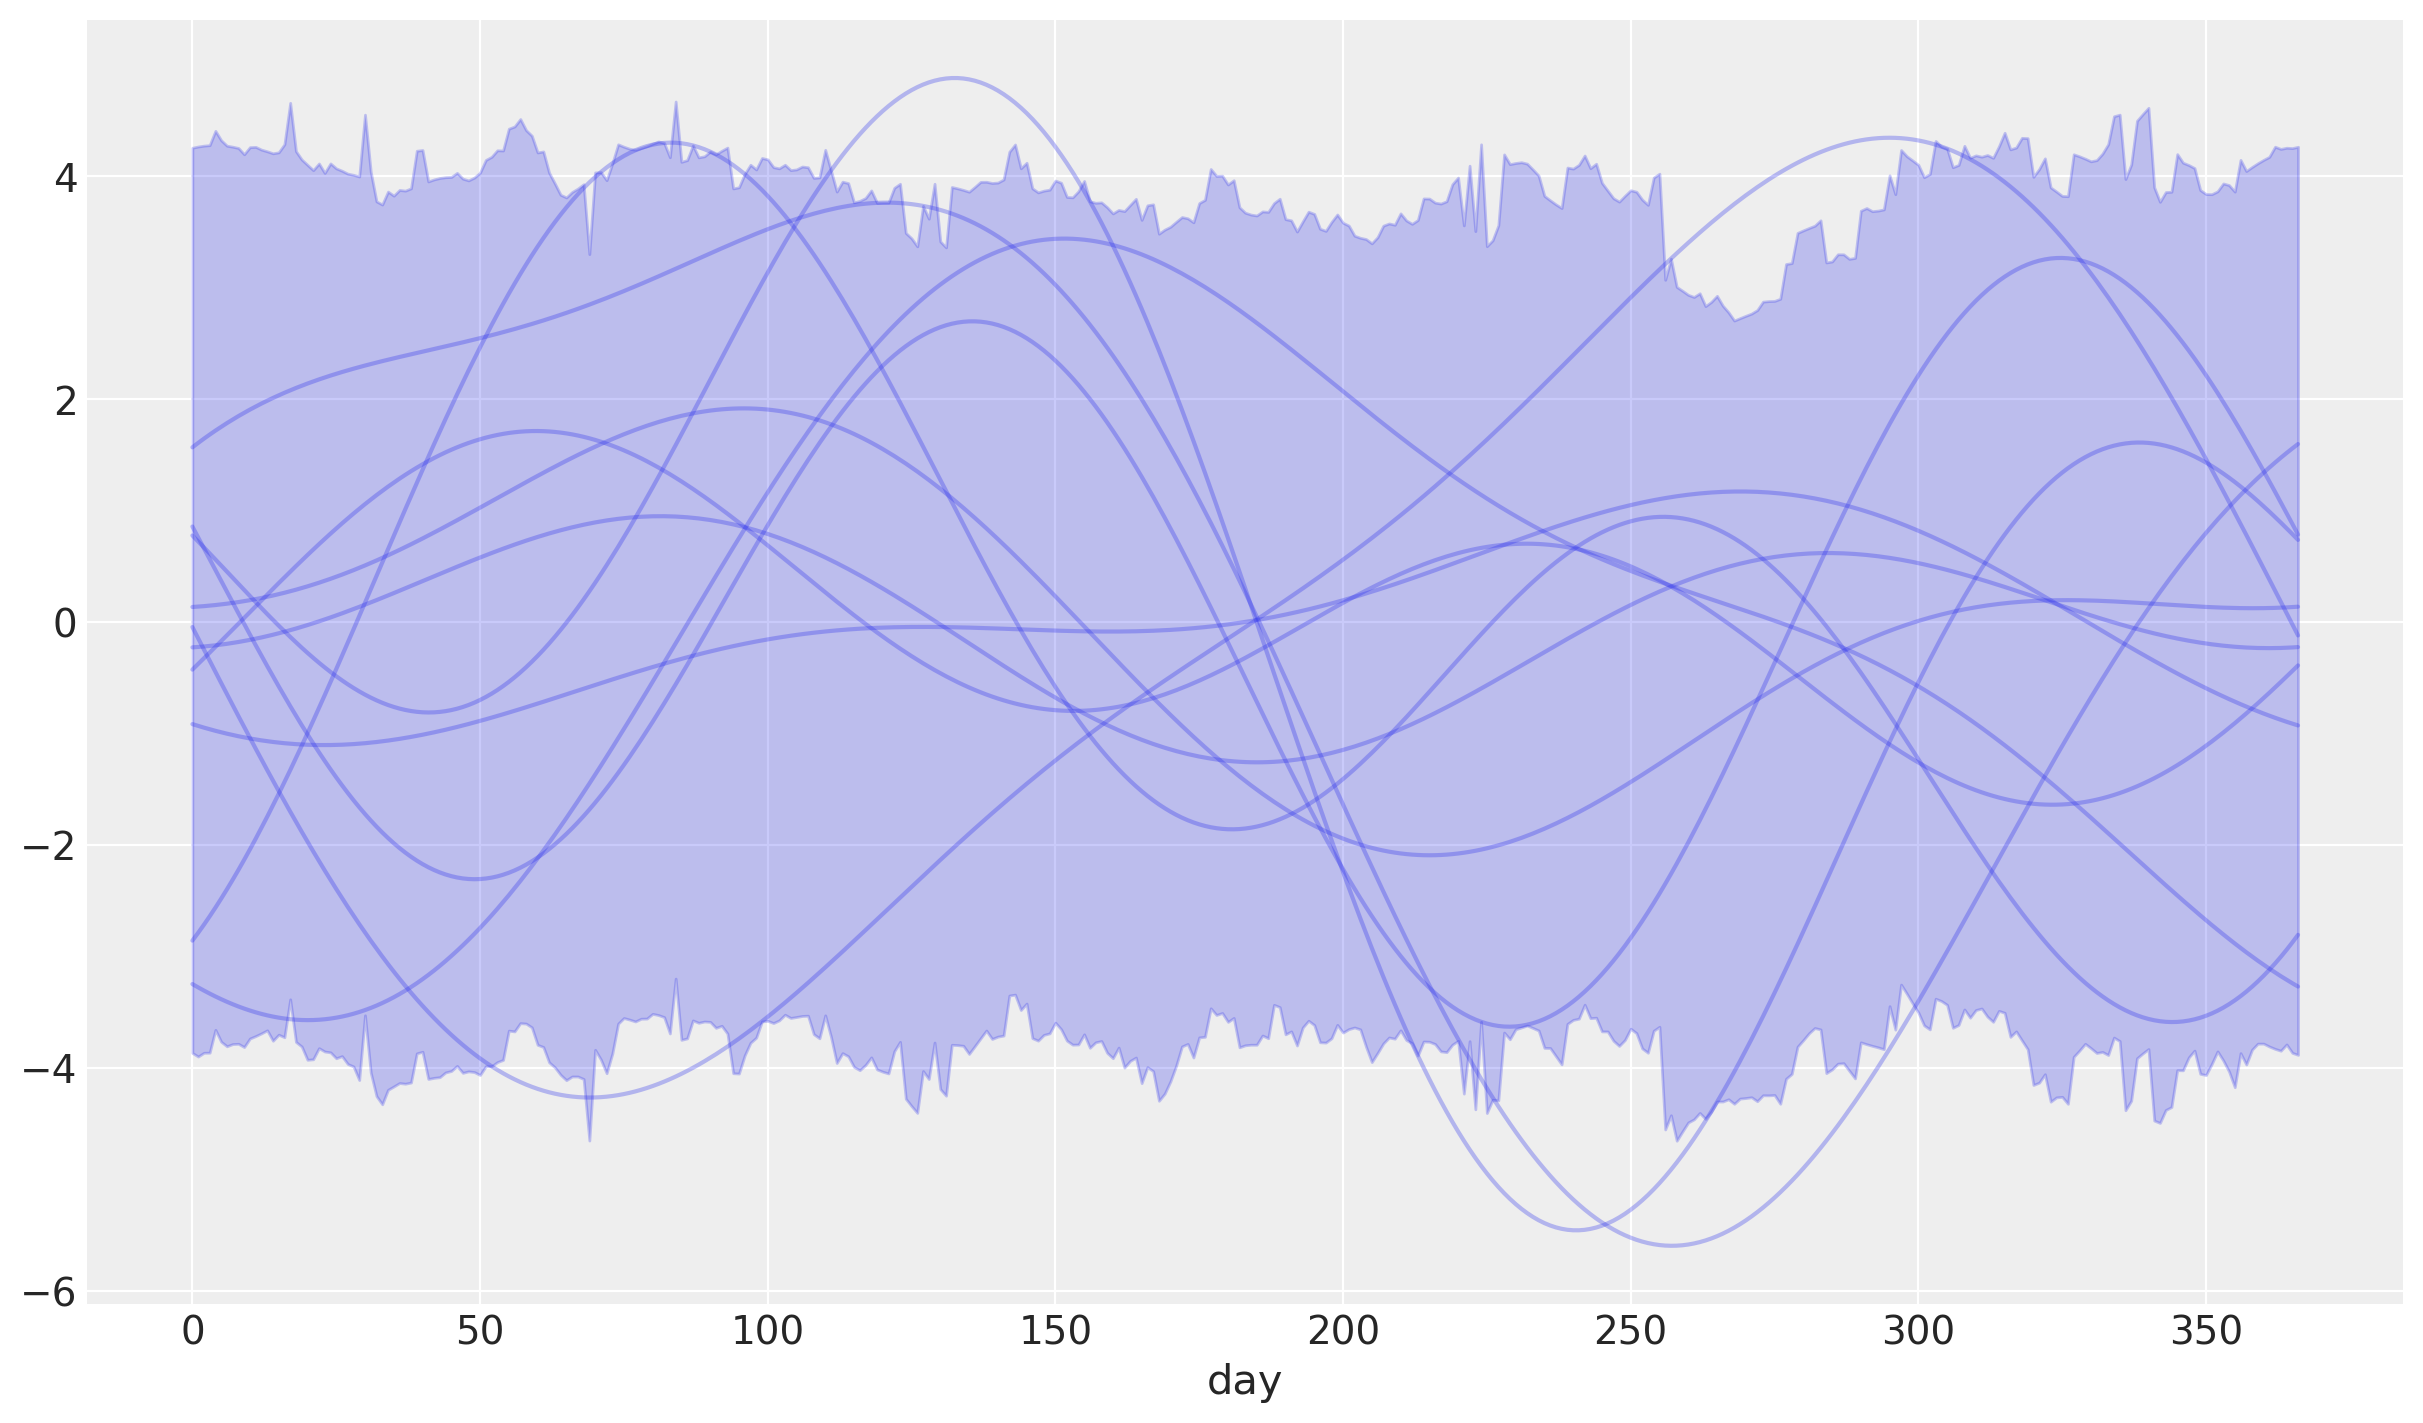

In [31]:
prior = yearly.sample_prior()
curve = yearly.sample_curve(prior)
yearly.plot_curve(curve);

This also supports arbitrary hierarchies that can be defined with the `Prior` class. Pass these in with the `prior` parameters. 

```{note}
A dimension associated with the prefix will be required! By default it is `fourier`
```

In [32]:
prior = Prior(
    "Normal",
    mu=[0, 0, -1, 0],
    sigma=Prior("Gamma", mu=0.15, sigma=0.1, dims="fourier"),
    dims=("geo", "fourier"),
)
yearly = mmm.YearlyFourier(n_order=2, prior=prior)

The above workflow works here as well! The coords just need to be passed like in `pm.Model`.

In [33]:
coords = {
    "geo": ["A", "B"],
}
prior = yearly.sample_prior(coords=coords)
curve = yearly.sample_curve(prior)

Sampling: [fourier_beta, fourier_beta_sigma]
Sampling: []


Output()

Based on the hierarchical priors, we can see similar seasonality betweens geos. However, they are not exactly the same!

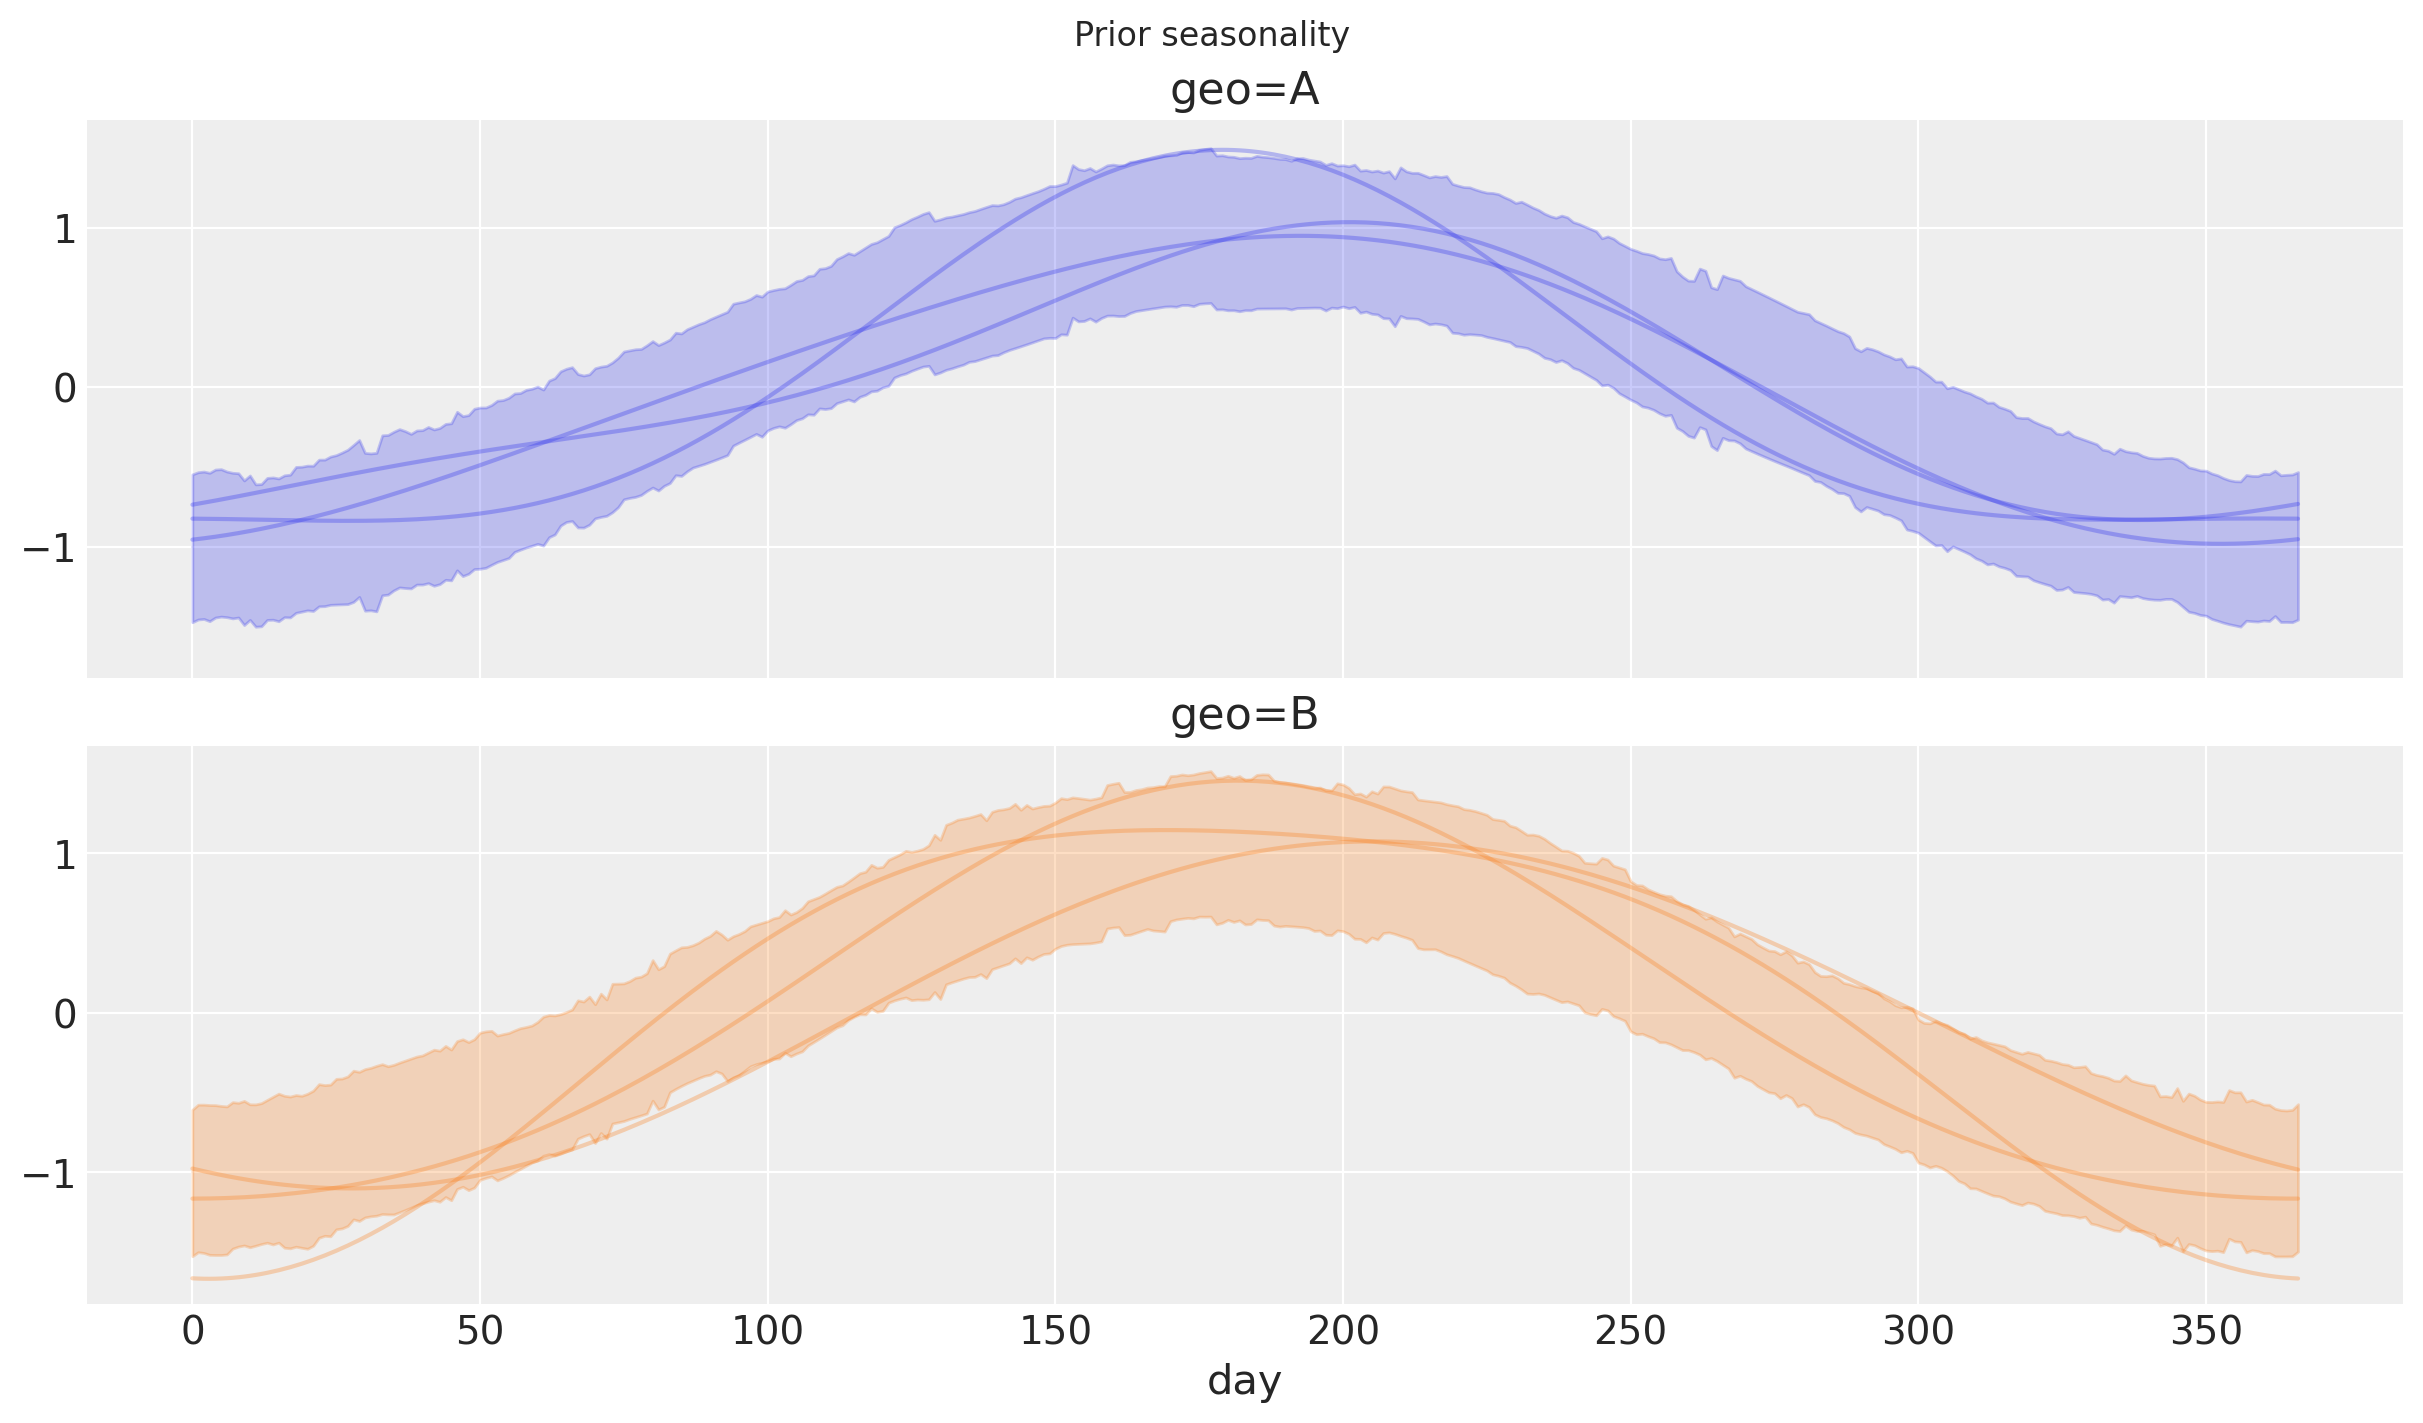

In [34]:
subplot_kwargs = {"ncols": 1}
sample_kwargs = {"n": 3}
fig, _ = yearly.plot_curve(
    curve, subplot_kwargs=subplot_kwargs, sample_kwargs=sample_kwargs
)
fig.suptitle("Prior seasonality");

## Events
You can add latent events using Gaussian Basis, this will [model events as Gaussian bumps](https://juanitorduz.github.io/bump_func/) as described by Juan Orduz.

Sampling: [basis_sigma, event_effect_size]
Sampling: [basis_sigma, event_effect_size]
Sampling: [basis_sigma, event_effect_size]
/var/folders/f0/rbz8xs8s17n3k3f_ccp31bvh0000gn/T/ipykernel_15926/1909437577.py:98: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


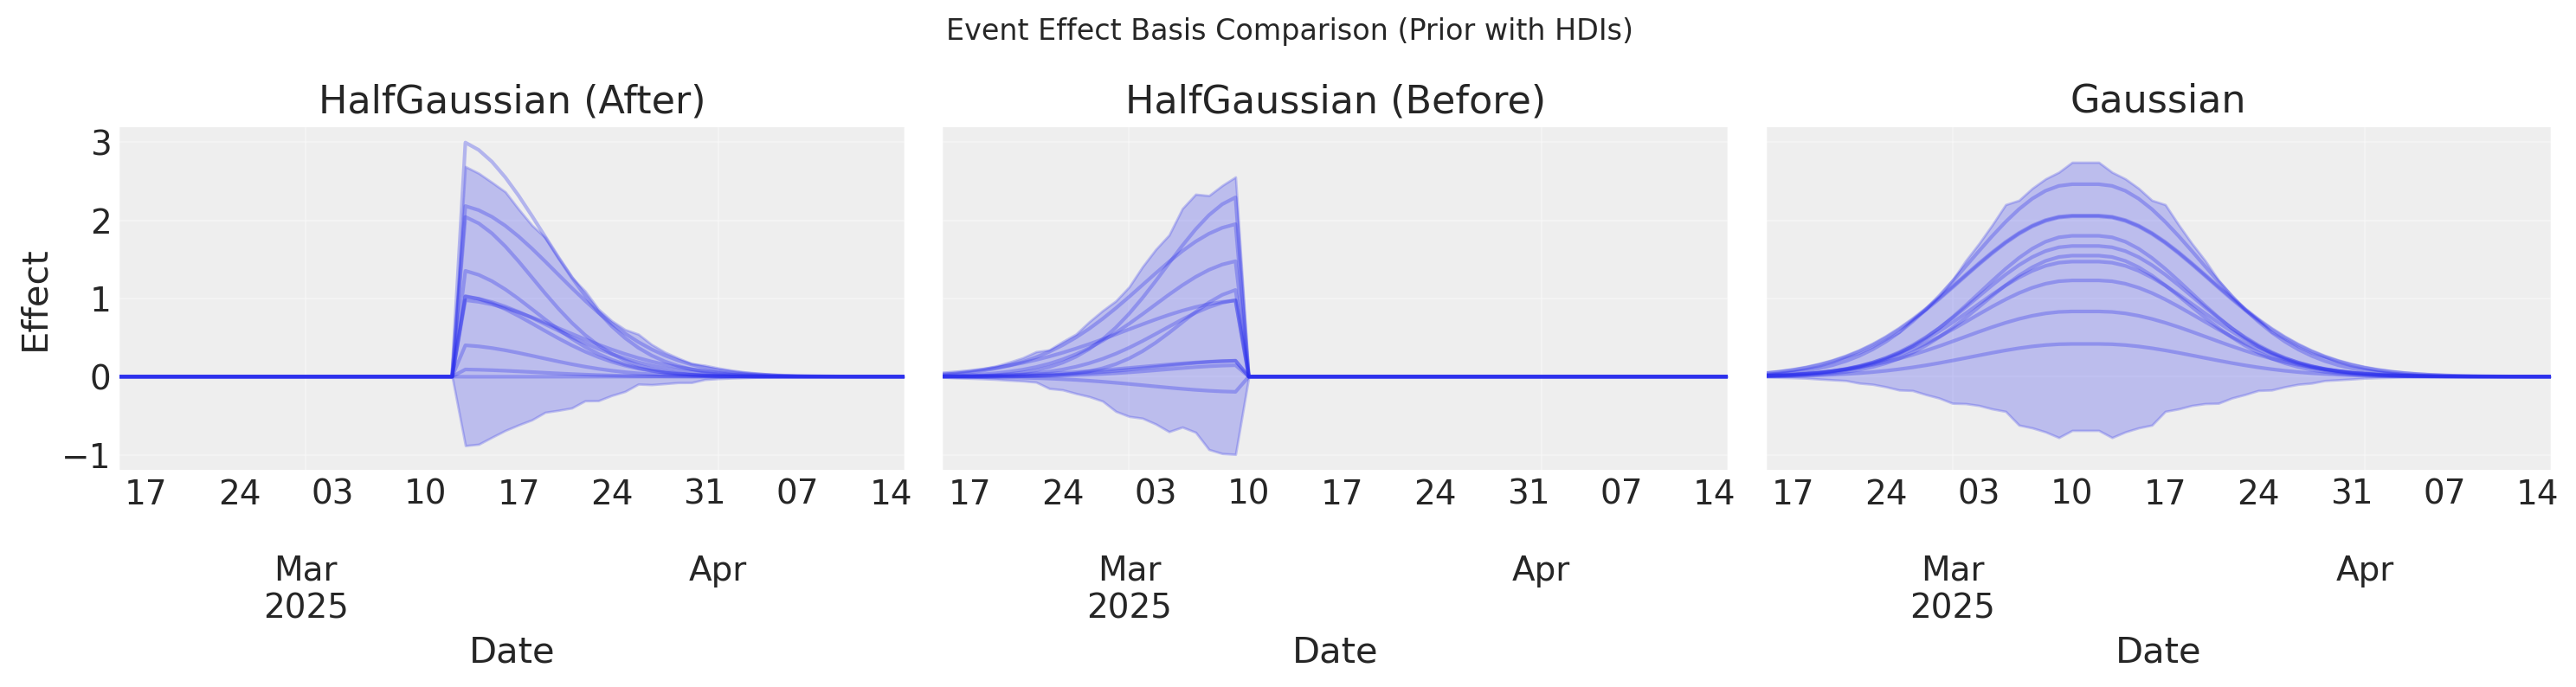

In [ ]:
# Example event window
df_events = pd.DataFrame(
    {
        "event": ["Product Launch"],
        "start_date": pd.to_datetime(["2025-03-10"]),
        "end_date": pd.to_datetime(["2025-03-12"]),
    }
)

# Build basis matrix of day offsets relative to event window


def difference_in_days(model_dates, event_dates):
    if hasattr(model_dates, "to_numpy"):
        model_dates = model_dates.to_numpy()
    if hasattr(event_dates, "to_numpy"):
        event_dates = event_dates.to_numpy()
    return (model_dates[:, None] - event_dates) / np.timedelta64(1, "D")


def create_basis_matrix(df_events: pd.DataFrame, model_dates: np.ndarray):
    start_dates = df_events["start_date"]
    end_dates = df_events["end_date"]

    s_ref = difference_in_days(model_dates, start_dates)
    e_ref = difference_in_days(model_dates, end_dates)

    return np.where(
        (s_ref >= 0) & (e_ref <= 0),
        0,
        np.where(np.abs(s_ref) < np.abs(e_ref), s_ref, e_ref),
    )


# Model dates and basis matrix
n_days = 60
dates = pd.date_range("2025-02-15", periods=n_days, freq="D")
X = create_basis_matrix(df_events, model_dates=dates)

# Create three different event effects
half_after = HalfGaussianBasis(
    priors={
        "sigma": Prior("Gamma", mu=7, sigma=1, dims="event"),
    },
    mode="after",
    include_event=False,
)

half_before = HalfGaussianBasis(
    priors={
        "sigma": Prior("Gamma", mu=7, sigma=1, dims="event"),
    },
    mode="before",
    include_event=False,
)

gaussian = GaussianBasis(
    priors={
        "sigma": Prior("Gamma", mu=7, sigma=1, dims="event"),
    },
)

effect_size = Prior("Normal", mu=1, sigma=1, dims="event")

# Create effects for each basis
effect_after = EventEffect(basis=half_after, effect_size=effect_size, dims=("event",))
effect_before = EventEffect(basis=half_before, effect_size=effect_size, dims=("event",))
effect_gaussian = EventEffect(basis=gaussian, effect_size=effect_size, dims=("event",))

coords = {"date": dates, "event": df_events["event"].to_numpy()}

# Sample prior curves for all three effects
curves = {}
for name, effect in [
    ("HalfGaussian (After)", effect_after),
    ("HalfGaussian (Before)", effect_before),
    ("Gaussian", effect_gaussian),
]:
    with pm.Model(coords=coords):
        event_curve = pm.Deterministic(
            "effect", effect.apply(X), dims=("date", "event")
        )
        idata = pm.sample_prior_predictive()
    curves[name] = idata.prior["effect"]

# Plot all three effects with HDIs and samples using plot_curve
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for i, (name, curve) in enumerate(curves.items()):
    _fig, _axes = plot_curve(
        curve,
        "date",
        n_samples=10,
        axes=np.array([axes[i]]),
    )
    axes[i].set_title(name)
    axes[i].set_xlabel("Date")
    axes[i].grid(True, alpha=0.3)

axes[0].set_ylabel("Effect")
fig.suptitle("Event Effect Basis Comparison (Prior with HDIs)")
fig.tight_layout()

Sampling: [basis_a_after, basis_sigma_after, basis_sigma_before]
Sampling: [basis_a_after, basis_sigma_after, basis_sigma_before]
Sampling: [basis_a_after, basis_sigma_after, basis_sigma_before]
/var/folders/5k/zzhl1wl12z1gfncb77xp4vzm0000gn/T/ipykernel_19032/4249197044.py:98: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


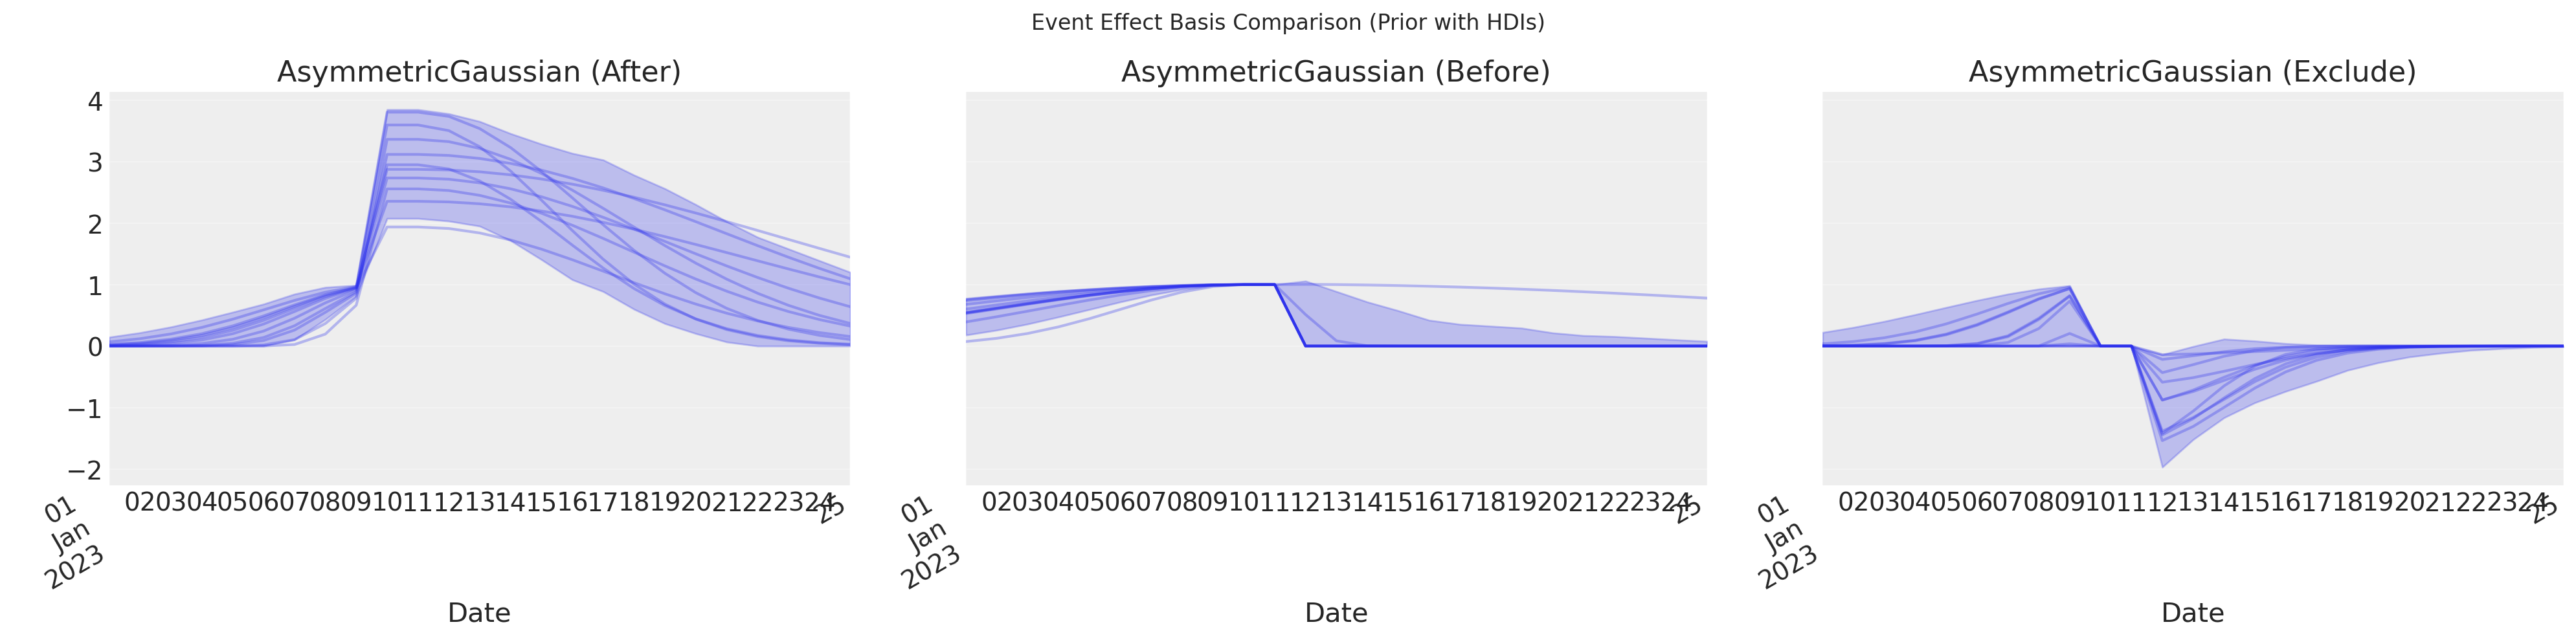

In [87]:
df_events = pd.DataFrame(
    {
        "event": ["e1"],
        "start_date": pd.to_datetime(["2023-01-10"]),
        "end_date": pd.to_datetime(["2023-01-11"]),
    }
)

dates = pd.date_range("2023-01-01", periods=25, freq="D")


def create_basis_matrix(df_events: pd.DataFrame, model_dates: np.ndarray):
    start_dates = df_events["start_date"]
    end_dates = df_events["end_date"]
    s_ref = difference_in_days(model_dates, start_dates)
    e_ref = difference_in_days(model_dates, end_dates)
    return np.where(
        (s_ref >= 0) & (e_ref <= 0),
        0,
        np.where(np.abs(s_ref) < np.abs(e_ref), s_ref, e_ref),
    )


X = create_basis_matrix(df_events, dates)

asymmetric_after = AsymmetricGaussianBasis(
    priors={
        "sigma_before": Prior("Gamma", mu=3, sigma=1, dims="event"),
        "sigma_after": Prior("Gamma", mu=7, sigma=2, dims="event"),
        "a_after": Prior("Normal", mu=3, sigma=0.5, dims="event"),
    },
    event_in="after",
)

asymmetric_before = AsymmetricGaussianBasis(
    priors={
        "sigma_before": Prior("Gamma", mu=8, sigma=2, dims="event"),
        "sigma_after": Prior("Gamma", mu=1, sigma=5, dims="event"),
        "a_after": Prior("Normal", mu=1, sigma=0.5, dims="event"),
    },
    event_in="before",
)

asymmetric_exclude = AsymmetricGaussianBasis(
    priors={
        "sigma_before": Prior("Gamma", mu=2, sigma=2, dims="event"),
        "sigma_after": Prior("Gamma", mu=3, sigma=1, dims="event"),
        "a_after": Prior("Normal", mu=-1, sigma=0.5, dims="event"),
    },
    event_in="exclude",
)

effect_size = Prior("Normal", mu=1, sigma=1, dims="event")

effect_after = EventEffect(
    basis=asymmetric_after, effect_size=effect_size, dims=("event",)
)
effect_before = EventEffect(
    basis=asymmetric_before, effect_size=effect_size, dims=("event",)
)
effect_exclude = EventEffect(
    basis=asymmetric_exclude, effect_size=effect_size, dims=("event",)
)

coords = {"date": dates, "event": df_events["event"].to_numpy()}

# Sample prior curves for all three effects
curves = {}
for name, effect in [
    ("AsymmetricGaussian (After)", asymmetric_after),
    ("AsymmetricGaussian (Before)", asymmetric_before),
    ("AsymmetricGaussian (Exclude)", asymmetric_exclude),
]:
    with pm.Model(coords=coords):
        event_curve = pm.Deterministic(
            "effect", effect.apply(X), dims=("date", "event")
        )
        idata = pm.sample_prior_predictive()
    curves[name] = idata.prior["effect"]

# Plot all three effects with HDIs and samples using plot_curve
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

for i, (name, curve) in enumerate(curves.items()):
    _fig, _axes = plot_curve(
        curve,
        "date",
        n_samples=10,
        axes=np.array([axes[i]]),
    )
    axes[i].set_title(name)
    axes[i].set_xlabel("Date")
    axes[i].grid(True, alpha=0.3)

# Rotate and align nicely
fig.autofmt_xdate(rotation=30)
fig.suptitle("Event Effect Basis Comparison (Prior with HDIs)")
fig.tight_layout()

## Example Custom MMM

Lots of flexibility by combining them together. This will build off the example above and now include an adstock transformation of the data as well.

In [36]:
def create_media_transformation(adstock, saturation, adstock_first: bool = True):
    """Flexible media transformation which allows for order to transformations."""
    first, second = (adstock, saturation) if adstock_first else (saturation, adstock)

    def media_transformation(x, dims):
        return second.apply(first.apply(x, dims=dims), dims=dims)

    return media_transformation

Our adstock function will have a hierarchical parameter for each geo. Our configuration is flexible enough to change this as long as the final dims will broadcast with the data!

In [37]:
# For reference
mmm.GeometricAdstock.default_priors

{'alpha': Prior("Beta", alpha=1, beta=3)}

These are also hierarchical parameters but across a different dimensions than the saturation transformation.

In [38]:
hierarchical_alpha = Prior(
    "Beta",
    alpha=Prior("HalfNormal", sigma=1, dims="channel"),
    beta=Prior("HalfNormal", sigma=1, dims="channel"),
    dims=("channel", "geo"),
)
priors = {
    "alpha": hierarchical_alpha,
}
adstock = mmm.GeometricAdstock(l_max=10, priors=priors)

Then for some additional differences between geo and observations, we will assume an intercept and noise around observations. The intercept will be independent across geos and the noise will be assumed to be hierarchical across geos.

The `Prior` class will be used to reflect these assumptions outside of the model context

In [39]:
intercept_dist = Prior("Normal", mu=2.5, sigma=0.25, dims="geo")
sigma_dist = Prior(
    "Normal",
    mu=-1,
    sigma=Prior("Gamma", mu=0.25, sigma=0.05),
    dims="geo",
    transform="exp",
)

In [40]:
media_transformation = create_media_transformation(
    adstock, saturation, adstock_first=True
)

with pm.Model(coords=geo_coords) as geo_model:
    intercept = intercept_dist.create_variable("intercept")

    # Media
    geo_data = pm.Data(
        "geo_data",
        geo_spends.to_numpy(),
        dims=("date", "channel", "geo"),
    )
    channel_contributions = pm.Deterministic(
        "channel_contributions",
        media_transformation(geo_data, dims=("channel", "geo")),
        dims=("date", "channel", "geo"),
    )

    media_contributions = pm.Deterministic(
        "media_contributions",
        channel_contributions.sum(axis=1),
        dims=("date", "geo"),
    )

    # Seasonality
    dayofyear = pm.Data(
        "dayofyear",
        geo_spends.coords["date"].dt.dayofyear.to_numpy(),
        dims="date",
    )
    fourier_trend = pm.Deterministic(
        "fourier_trend",
        yearly.apply(dayofyear),
        # Because of the prior
        dims=("date", "geo"),
    )

    # Combined
    mu = pm.Deterministic(
        "mu",
        intercept + media_contributions + fourier_trend,
        dims=("date", "geo"),
    )

    sigma = sigma_dist.create_variable("target_sigma")
    target = pm.Normal(
        "target",
        mu=mu,
        sigma=sigma,
        dims=("date", "geo"),
        # observed=...,
    )

The combined data generation process can be seen below:

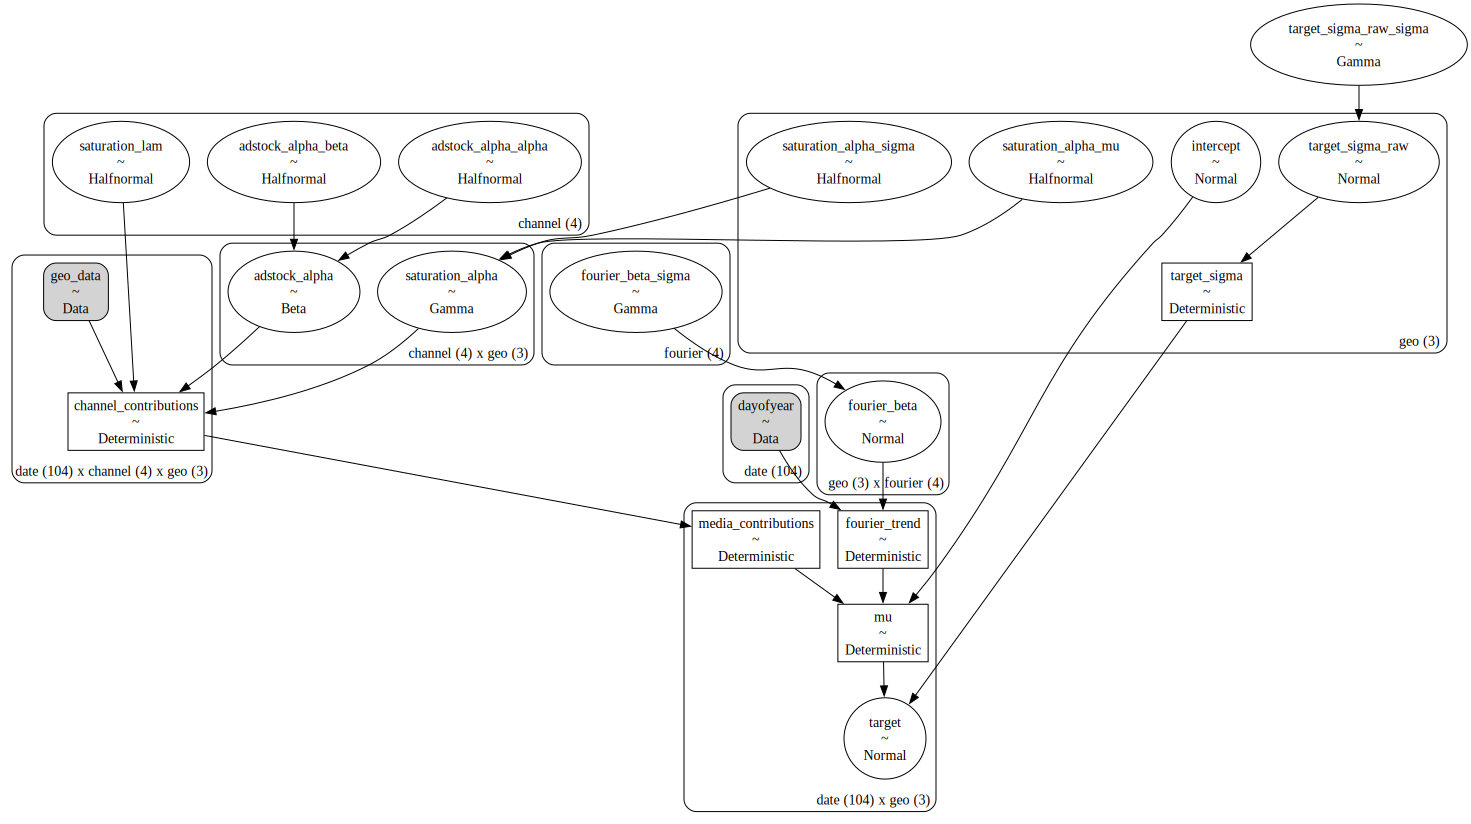

In [41]:
pm.model_to_graphviz(geo_model)

We can then sample from this model to investigate the target variable of the MMM.

In [42]:
with geo_model:
    prior = pm.sample_prior_predictive(random_seed=rng).prior

prior

Sampling: [adstock_alpha, adstock_alpha_alpha, adstock_alpha_beta, fourier_beta, fourier_beta_sigma, intercept, saturation_alpha, saturation_alpha_mu, saturation_alpha_sigma, saturation_lam, target, target_sigma_raw, target_sigma_raw_sigma]


<xarray.Dataset> Size: 10MB
Dimensions:                 (chain: 1, draw: 500, channel: 4, geo: 3,
                             fourier: 4, date: 104)
Coordinates:
  * chain                   (chain) int64 8B 0
  * draw                    (draw) int64 4kB 0 1 2 3 4 5 ... 495 496 497 498 499
  * channel                 (channel) <U2 32B 'C1' 'C2' 'C3' 'C4'
  * geo                     (geo) <U7 84B 'Region1' 'Region2' 'Region3'
  * fourier                 (fourier) <U5 80B 'sin_1' 'sin_2' 'cos_1' 'cos_2'
  * date                    (date) datetime64[ns] 832B 2023-01-02 ... 2024-12-23
Data variables: (12/18)
    adstock_alpha_alpha     (chain, draw, channel) float64 16kB 0.1712 ... 0....
    fourier_beta            (chain, draw, geo, fourier) float64 48kB -0.05167...
    target                  (chain, draw, date, geo) float64 1MB 1.998 ... 3.558
    channel_contributions   (chain, draw, date, channel, geo) float64 5MB 0.0...
    target_sigma            (chain, draw, geo) float64 12kB 0.2758 ... 0.327
    target_sigma_raw        (chain, draw, geo) float64 12kB -1.288 ... -1.118
    ...                      ...
    media_contributions     (chain, draw, date, geo) float64 1MB 0.3226 ... 0...
    adstock_alpha           (chain, draw, channel, geo) float64 48kB 0.000227...
    intercept               (chain, draw, geo) float64 12kB 2.53 2.724 ... 2.999
    saturation_alpha_mu     (chain, draw, geo) float64 12kB 1.098 ... 0.2839
    adstock_alpha_beta      (chain, draw, channel) float64 16kB 0.5439 ... 1.782
    saturation_alpha        (chain, draw, channel, geo) float64 48kB 0.02628 ...
Attributes:
    created_at:                 2025-08-29T19:17:47.395992+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.25.1

We will use the `plot_curve` helper function to plot the `target` variable across time for each region. This shows the HDI and 2 prior samples for each of the 3 time series.

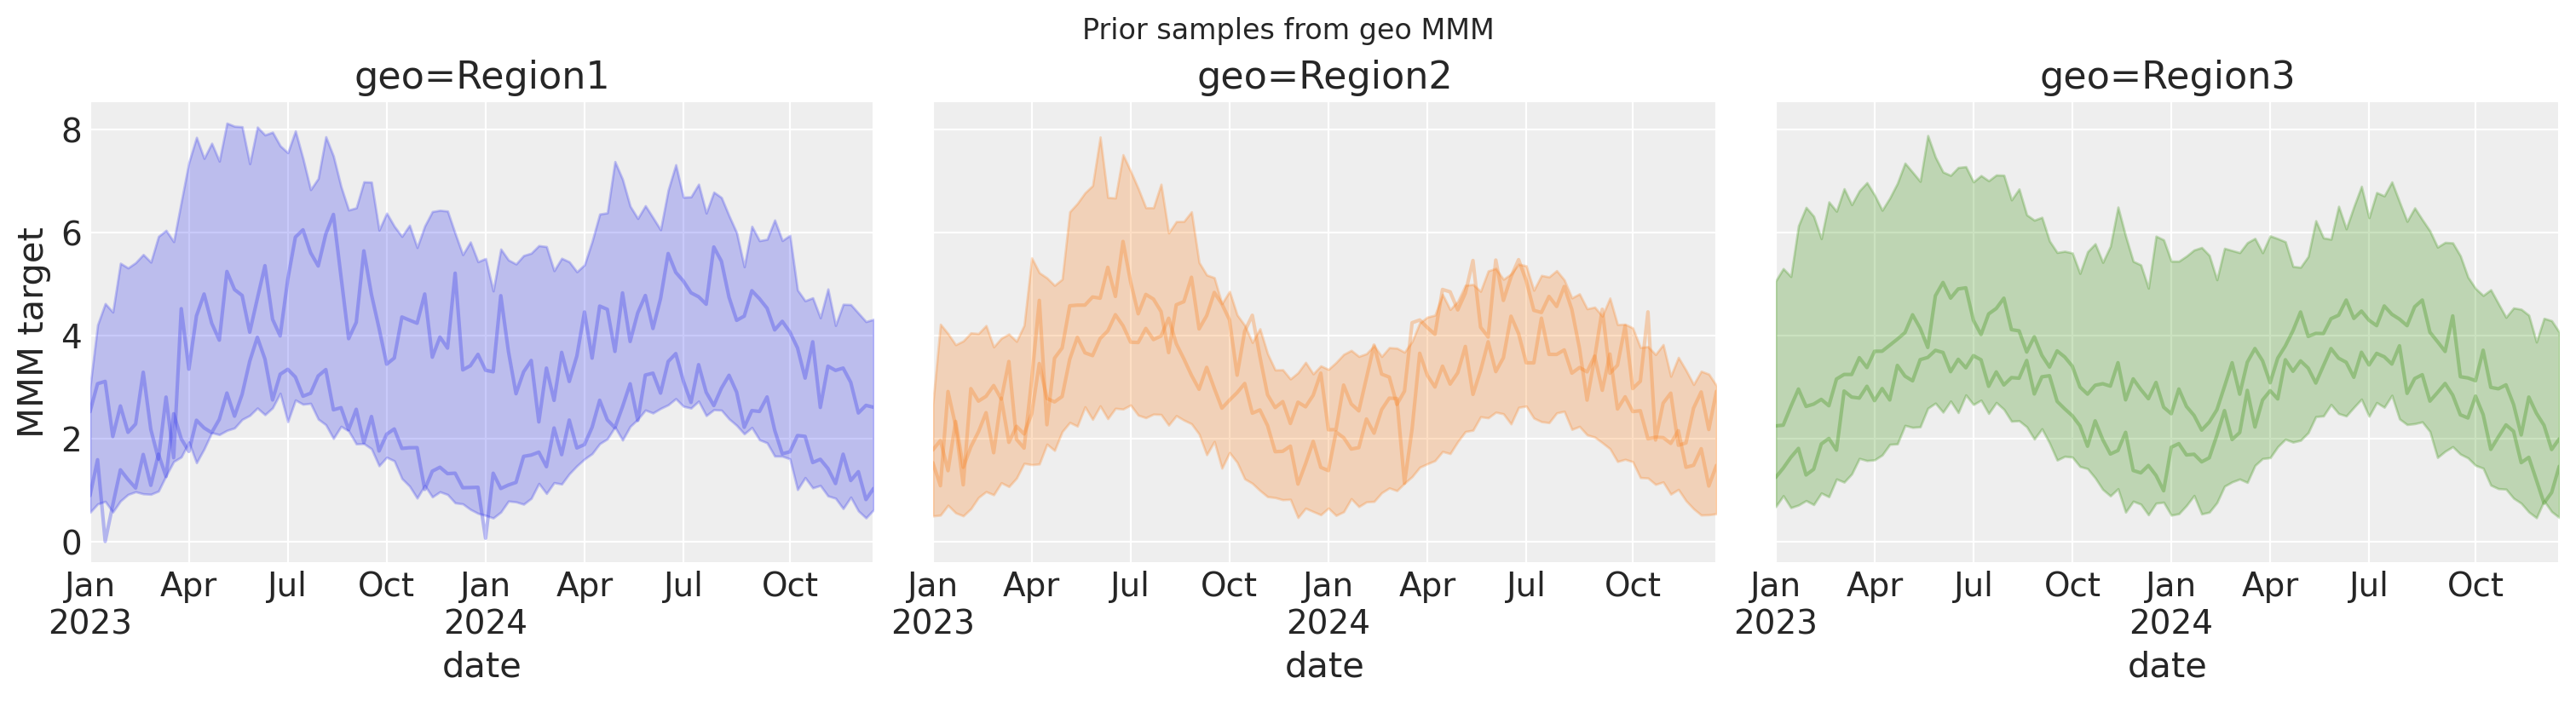

In [43]:
fig, axes = plot_curve(
    prior["target"],
    {"date"},
    sample_kwargs={
        "rng": rng,
        "n": 2,
    },
    subplot_kwargs={"ncols": 3, "figsize": (15, 4)},
)
axes[0].set(ylabel="MMM target")
fig.suptitle("Prior samples from geo MMM");

## Summary

Custom models are possible using the components that build up the `MMM` class and `PyMC` distributions themselves. With some prior distribution configuration and the components that PyMC-Marketing provides, novel models can be built up to fit various use-cases and various model assumptions.

Much of the flexibility will come from the prior distribution configuration rather then the transformation themselves. This is meant to keep a standard interface while working with them regardless what their role is.

If there is any suggestions or feedback on how to make better custom models with the package, [create a GitHub Issue](https://github.com/pymc-labs/pymc-marketing/issues/new) or chime into the various discussions.

Though models can be built up like this, the prebuilt structures provide many benefits as well. For instance, the `MMM` class provides:

- scaling of input and output data
- plotting methods for parameters, predictive data, contributions, etc
- customized adstock and saturation transformations
- out of sample predictions
- lift test integration
- budget optimization

Our recommendation is to start with the prebuilt models and work up from there.

In [44]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc_marketing,pytensor

Last updated: Fri Aug 29 2025

Python implementation: CPython
Python version       : 3.12.11
IPython version      : 9.4.0

pymc_marketing: 0.15.1
pytensor      : 2.31.7

numpy         : 2.2.6
pandas        : 2.3.1
matplotlib    : 3.10.3
xarray        : 2025.7.1
pymc_marketing: 0.15.1
pymc          : 5.25.1
pymc_extras   : 0.4.0
arviz         : 0.22.0

Watermark: 2.5.0

